# **<span style = 'color:blue'>Box-Jenkins Approach in model building</span>**

## **<span style='color:green'> Contents:</span>**<a id="Table"></a>

* [1. Import the libraries](#Import)
* [2. Dataset Information](#Dataset)
* [3. Box-Jenkins Approach in model building](#Box-Jenkins)
    - [3.1 Model Identification](#Identification)
        > * [3.1.1 Visualize the Time Series to study the original plot](#Visualize)
        > * [3.1.2 Decomposition of individual components](#Decomposition)
        > * [3.1.3 Statistical Data Summary with Tableone](#Tableone)
        > * [3.1.4 Testing Causation using Granger’s Causality Test](#Causality)
        > * [3.1.5 Johanssen Cointegration Test](#Cointegration)
        > * [3.1.6 Cross-correlation plot](#Cross-correlation)
    - [3.2. Model Estimation and Evaluation](#Estimation)
        > * [3.2.1 Estimation of non-seasonal order (d): Check for Stationarity and Make the Time Series Stationary](#Stationarity)
        > * [3.2.2 Estimation of Non-seasonal orders (p, d, q) by hyper parameter grid search tuning](#Non-seasonal)
        > * [3.2.3 Lag plot](#Lagplot)
        > * [3.2.4 Partial Autocorrelation Plot of the Indoor Temperatures](#PACF-Plot)
        > * [3.2.5. Estimation od non-seasonal order (q): Autocorrelation Plot of the Indoor Temperatures](#q)
    - [3.3 Model Checking (Goodness of fit)/Model Verification/Model Diagnostics)](#Diagnostics)
        > * [3.3.1 Check for Serial Correlation of Residuals (Errors) using Durbin Watson Statistic](#DWStatistic)
        > * [3.3.2 Prediction / Forecast with ARIMA model using statsmodels](#Prediction)
        > * [3.3.3 Residual Plots](#Residual)
        > * [3.3.4 Evaluation metrics using Forecasts](#Metrics)
        > * [3.3.5 Normality Test for Residuals](#Normality)
        > * [3.3.6 Autocorrelation of residuals](#Autocorrelation)
        > * [3.3.7 Heteroscedasticity Analysis of Residuals: Breusch-Pagan, Goldfeld-Quandt and White Tests in Python](#Heteroscedasticity)
        > * [3.3.8 Prediction Intervals](#Intervals)    
        > * [3.3.9 Checking for Conditional Heteroskedasticity](#Conditional-Heteroskedasticity)
* [4. SARIMA model building](#Sarima)
    - [4.1 Model Identification & Estimation: Finding Non-seasonal and Seasonal Orders](#Finding-orders)
        > * [4.1.1 Plot the decomposition of a time series](#decomposition)
        > * [4.1.2 Plot correlograms PACF & ACF plots](#correlogram)
        > * [4.1.3 Estimation of parameters using AIC, BIC, FPE and HQIC](#AIC)
        > * [4.1.4 Using auto_arima](#auto-arima)
    - [4.2 Model Diagnostics](#Sarima-Diagnostics)

## **<span style = 'color:green'>1. Import the required libraries</span>**<a id ="Import"></a>

In [1]:
# Import data handling & numerical libraries
import pandas as pd
import numpy as np
from copy import copy
import datetime

# Import Data Visualization libraries
import seaborn as sb
import matplotlib.pyplot as plt

#import libraries for muting unnecessary warnings if needed
import warnings
warnings.filterwarnings('ignore')

## **<span style = 'color:green'>2. Dataset information</span>**<a id ='Dataset'></a>
[<div style="text-align: right"> Back to Table of contents</div>](#Table)

The dataset collected from the monitor system mounted in a solar house corresponds to approximately 40 days of monitoring data. The Goal is to predict indoor temperature of a room (the Bedroom), in order to choose whether or not to activate the HVAC (Heating, Ventilation, and Air Conditioning) system. The data was sampled every minute, computing and uploading it smoothed with 15 minute means. The dataset includes dates, other sensor measurements, weather measurements and other information. It is a multivariate time-series dataset.
It has been established that the power consumption attributed to HVAC accounts for 53.9 % of total consumption, and the energy required to maintain the temperature is less than that required to drop or raise it.
As a result, a predictive model capable of predicting a room's indoor temperature (a short-term forecast of indoor temperature) would help in lowering overall energy consumption, by deciding whether or not to activate the HVAC system, at the appropriate time.
Below displayed map provides an idea of locations of solar house sensors and actuators.

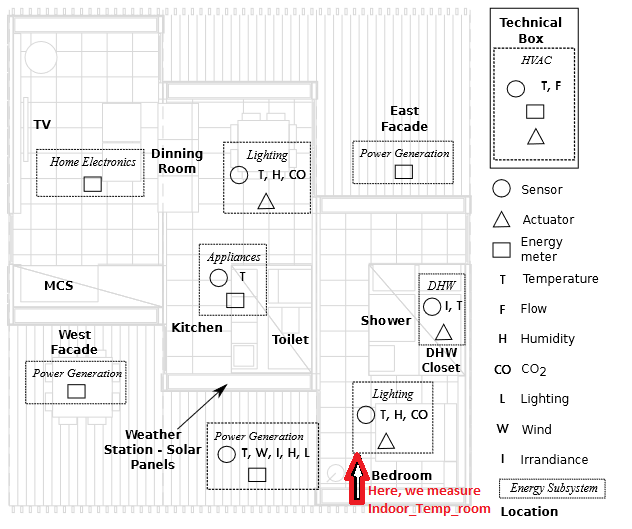

In [2]:
from IPython.display import Image
url = '../input/smart-homes-temperature-time-series-forecasting/Solar house sensors and actuators map.png'
Image(url,width=700, height=700)

In [3]:
df1 = pd.read_csv('../input/smart-homes-temperature-time-series-forecasting/train.csv')
df1

,Id,Date,Time,CO2_(dinning-room),CO2_room,Relative_humidity_(dinning-room),Relative_humidity_room,Lighting_(dinning-room),Lighting_room,Meteo_Rain,Meteo_Sun_dusk,Meteo_Wind,Meteo_Sun_light_in_west_facade,Meteo_Sun_light_in_east_facade,Meteo_Sun_light_in_south_facade,Meteo_Sun_irradiance,Outdoor_relative_humidity_Sensor,Day_of_the_week,Indoor_temperature_room
0,0,13/03/2012,11:45,216.560,221.920,39.9125,42.4150,81.6650,113.5200,0.0,623.360,1.426250,9690.24,12604.20,95436.800,758.8800,48.3750,2.0,17.8275
1,1,13/03/2012,12:00,219.947,220.363,39.9267,42.2453,81.7413,113.6050,0.0,623.211,1.592000,11022.00,10787.20,95436.800,762.0690,47.8080,2.0,18.1207
2,2,13/03/2012,12:15,219.403,218.933,39.7720,42.2267,81.4240,113.6000,0.0,622.656,1.891330,13960.50,9669.63,95398.600,766.2510,47.4320,2.0,18.4367
3,3,13/03/2012,12:30,218.613,217.045,39.7760,42.0987,81.5013,113.3440,0.0,622.571,1.828000,18511.20,9648.13,95360.300,766.0370,47.0240,2.0,18.7513
4,4,13/03/2012,12:45,217.714,216.080,39.7757,42.0686,81.4657,113.0340,0.0,622.400,2.360710,26349.00,9208.32,95354.900,762.7430,45.4743,2.0,19.0414
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2759,2759,11/04/2012,05:30,190.539,192.181,41.3120,41.6880,11.4427,12.9400,0.0,392.603,0.074667,0.00,0.00,0.000,-3.4340,49.2960,3.0,20.8187
2760,2760,11/04/2012,05:45,190.421,193.067,41.3173,41.7200,11.6867,19.3200,0.0,613.120,0.000000,465.92,2716.67,523.264,3.8520,50.0373,3.0,20.7053
2761,2761,11/04/2012,06:00,190.432,193.653,41.3333,41.7573,19.5387,23.2427,0.0,613.803,0.310667,3454.98,16203.80,3347.460,26.8300,50.0587,3.0,20.5827
2762,2762,11/04/2012,06:15,191.531,193.387,41.3093,41.8107,20.9853,23.4400,0.0,615.403,0.299333,6795.26,38303.10,7110.660,66.9493,49.8400,3.0,20.5200


In [4]:
df = df1.copy()
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df['Date'] = df['Date'].dt.strftime('%Y-%m-%d')
    
df['DateTime'] = df['Date'] + ' ' + df['Time']
df['DateTime'] = pd.to_datetime(df['DateTime'])
df.drop(['Date','Time'], axis = 1, inplace = True)
df['hour'] = df['DateTime'].apply(lambda x : x.hour)
df = df.set_index('DateTime')
df.index = pd.DatetimeIndex(df.index.values, freq='15T')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2764 entries, 2012-03-13 11:45:00 to 2012-04-11 06:30:00
Freq: 15T
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Id                                2764 non-null   int64  
 1   CO2_(dinning-room)                2764 non-null   float64
 2   CO2_room                          2764 non-null   float64
 3   Relative_humidity_(dinning-room)  2764 non-null   float64
 4   Relative_humidity_room            2764 non-null   float64
 5   Lighting_(dinning-room)           2764 non-null   float64
 6   Lighting_room                     2764 non-null   float64
 7   Meteo_Rain                        2764 non-null   float64
 8   Meteo_Sun_dusk                    2764 non-null   float64
 9   Meteo_Wind                        2764 non-null   float64
 10  Meteo_Sun_light_in_west_facade    2764 non-null   float64
 11  Meteo_Sun_light_in_east

In [6]:
df.describe()

,Id,CO2_(dinning-room),CO2_room,Relative_humidity_(dinning-room),Relative_humidity_room,Lighting_(dinning-room),Lighting_room,Meteo_Rain,Meteo_Sun_dusk,Meteo_Wind,Meteo_Sun_light_in_west_facade,Meteo_Sun_light_in_east_facade,Meteo_Sun_light_in_south_facade,Meteo_Sun_irradiance,Outdoor_relative_humidity_Sensor,Day_of_the_week,Indoor_temperature_room,hour
count,2764.000000,2764.000000,2764.000000,2764.000000,2764.000000,2764.000000,2764.000000,2764.000000,2764.000000,2764.000000,2764.000000,2764.000000,2764.000000,2764.000000,2764.000000,2764.000000,2764.000000,2764.000000
mean,1381.500000,208.479123,211.065844,44.878420,47.321220,26.745381,40.732571,0.047033,325.369289,1.108531,14936.617682,12248.000148,22047.525813,215.010017,55.981988,3.954438,18.824852,11.519899
std,798.042397,27.032686,28.469144,6.587440,7.557795,23.298441,42.326087,0.206705,305.062614,1.161283,25964.049455,21758.550527,32709.387051,297.234046,13.019610,1.991799,2.821178,6.943334
min,0.000000,187.339000,188.907000,27.084000,29.594700,10.740000,11.328000,0.000000,0.606667,0.000000,0.000000,0.000000,0.000000,-4.164670,22.260700,1.000000,11.076000,0.000000
25%,690.750000,200.893250,202.682750,40.351975,42.531325,11.588700,13.265300,0.000000,0.650000,0.094833,0.000000,0.000000,0.000000,-3.381330,46.430675,2.000000,17.060350,5.000000
50%,1381.500000,207.045500,209.408000,45.434650,47.534700,11.801300,17.690000,0.000000,611.797000,0.659000,0.000000,0.000000,0.000000,3.922000,57.477350,4.000000,19.021000,12.000000
75%,2072.250000,211.245500,213.218750,49.352675,52.685975,31.224000,52.057350,0.000000,619.210750,1.971497,15088.000000,11131.275000,38736.575000,435.434500,65.649325,6.000000,20.828700,18.000000
max,2763.000000,594.389000,609.237000,60.957300,62.594700,110.693000,162.965000,1.000000,624.960000,6.321330,95278.400000,85535.400000,95704.400000,1028.270000,83.805300,7.000000,24.944000,23.000000


## **<span style='color:green'>3. Box-Jenkins Approach in model building</span>**<a id ='Box-Jenkins'></a>
[<div style="text-align: right"> Back to Table of contents</div>](#Table)

This project discusses the analyses of time series by following the Box-Jenkins Approach in model building. Box-Jenkins forecasting models involves four-steps  as follows: 
> 1. Model Identification, 
> 2. Model Estimation, 
> 3. Model Checking (Goodness of fit) 
> 4. Model Forecasting.

### **<span style = 'color:brown'>3.1 Model Identification</span>**<a id ='Identification'></a>
[<div style="text-align: right"> Back to Table of contents</div>](#Table)
The model identification process is done by the following:
1. studying the original plot, 
2. analyze for causality
3. analyze for cointegration
3. analyze for cross correlation
4. checking whether it is stationary by performing various objective tests, like Kwiatkowski-Phillips-Schmidt-Shin (KPSS) and Augmented Dickey- Fuller (ADF) 
5. applying differencing to the raw data to ensure that it is stationary, and identifying d in the process, 
7. plotting lagplots and correlograms like PACF (for identifying 'p'), ACF (for identifying 'q') 


#### **<span style = 'color:purple'>3.1.1 Visualize the Time Series to study the original plot</span>**<a id ="Visualize"></a>
[<div style="text-align: right"> Back to Table of contents</div>](#Table)

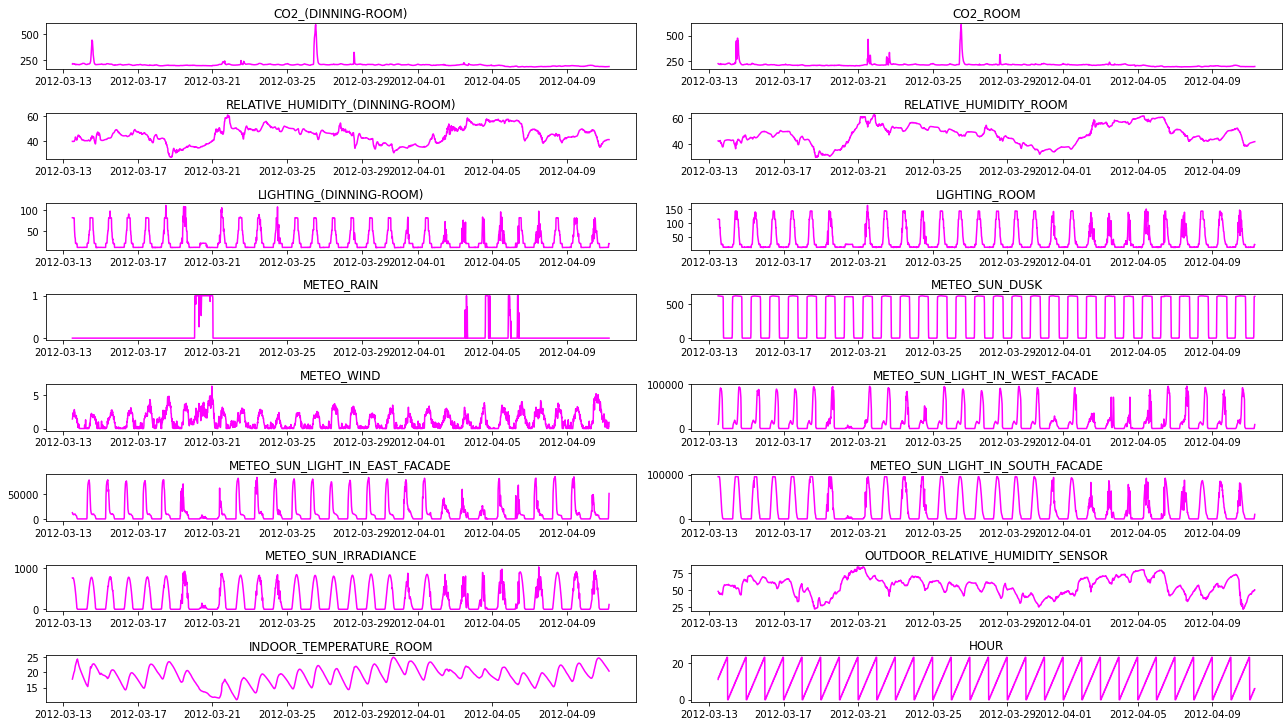

In [7]:
num_feats=[col for col in df.columns if df[col].dtypes != 'object'  and col !='Day_of_the_week' and col != 'Id']

# Plot distribution of numerical columns
fig=plt.figure(figsize=(18,20))
for i, col in enumerate(num_feats):
    plt.subplot(len(num_feats),2,1*i+1)
    plt.plot(df[col], color ='magenta')
    plt.title(col.upper())  
fig.tight_layout()
plt.show()

Reviewing the line plot, it suggests that there may be an increasing indoor temperature trend since 2012-03-21 and there is also seasonality and height of the cycles appears to be the same, suggesting that it is additive, rather than multiplicative.  The series like Meteo_Sun_Irradiance, Meteo_Wind, Meteo_Sunlight, humidity etc  have a fairly similar seasonality patterns over the days.

#### **<span style = 'color:purple'>3.1.2 Decomposition of individual components</span>**<a id ="Decomposition"></a>
[<div style="text-align: right"> Back to Table of contents</div>](#Table)
About stationary time series :
The observations in a stationary time series are not dependent on time.
Time series is stationary if it does not have trend or seasonal effects.
Summary statistics (like the mean or the variance) is consistent over time.(Homoscedastic; mean values at different time are constant).
Errors must follow a white noise i.e zero mean and constant variance.

Non - Statistical test for the question whether stationary or not can be :
Since the time series has both a trend and a seasonal component, it is not considered stationary We also observed in the previous questions that the data consisted of some trend and thus it is non stationary from the decomposed plots.
Can be seen from the plot of decomposed components

Decomposition is performed by seasonal_decompose() function of statsmodels.tsa class. Decompose the ​15min​ sampled data into trend, seasonality and residual. 

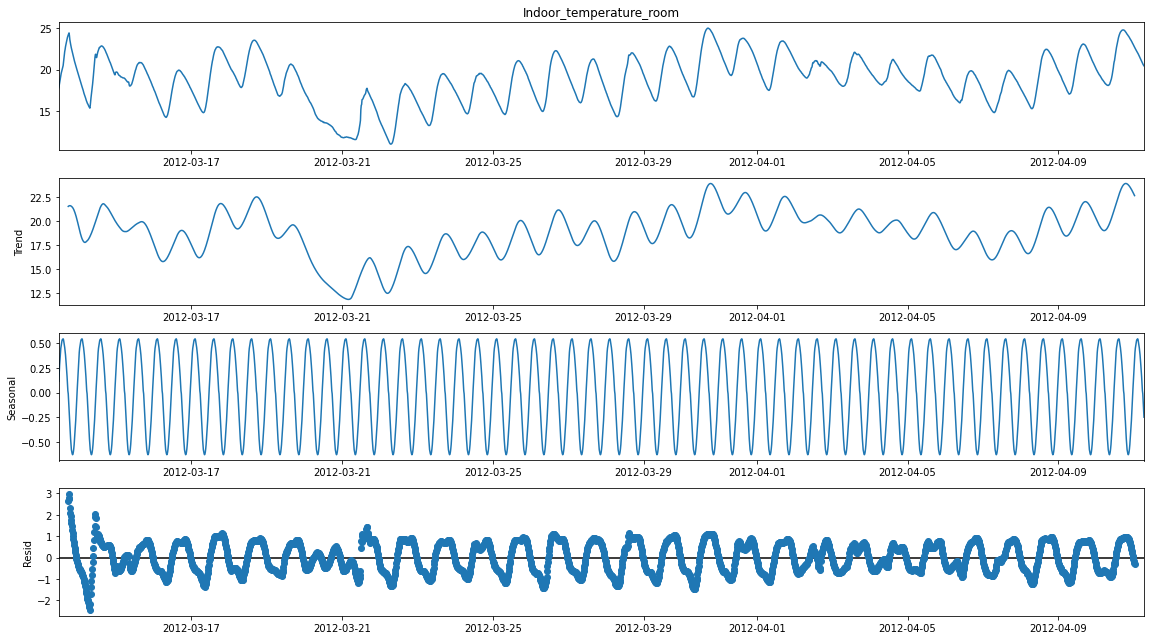

In [8]:
from statsmodels.tsa.seasonal import seasonal_decompose
decompose_data = seasonal_decompose(df['Indoor_temperature_room'], period=48)
fig = decompose_data.plot()
fig.set_size_inches((16, 9))
# Tight layout to realign things
fig.tight_layout()
plt.show();

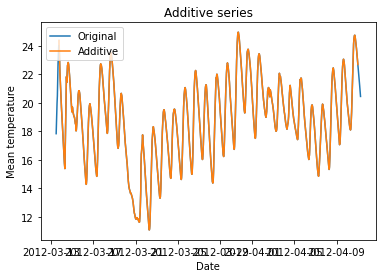

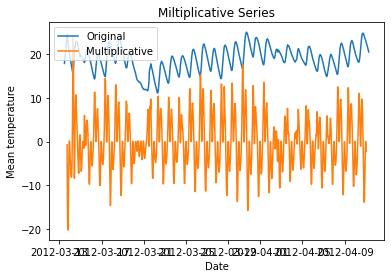

In [9]:
#To find if the series is additive or multiplicative we add the individual components 
#and see which out of additive or multiplicative can bring back the original data

additive = decompose_data.trend + decompose_data.seasonal + decompose_data.resid
multiplicative = decompose_data.trend * decompose_data.seasonal * decompose_data.resid

#Additive
plt.plot(decompose_data.observed, label="Original")
plt.plot(additive, label="Additive")
plt.xlabel('Date')
plt.ylabel('Mean temperature')
plt.title('Additive series')
plt.legend(loc=2)
plt.show()

#Multiplicative
plt.plot(decompose_data.observed, label="Original")
plt.plot(multiplicative, label="Multiplicative")
plt.xlabel('Date')
plt.ylabel('Mean temperature')
plt.title('Miltiplicative Series')
plt.legend(loc=2)
plt.show()


It can be seen that the additive and the observed components overlap completely whereas the multiplicative doesn't overlap with the observed. This shows that the time series is additive.

#### **<span style = 'color:purple'>3.1.3 Statistical Data Summary with Tableone</span>**<a id ="Tableone"></a>
[<div style="text-align: right"> Back to Table of contents</div>](#Table)

In [10]:
pip install tableone --quiet

Note: you may need to restart the kernel to use updated packages.


In [11]:
#Import tableone
from tableone import TableOne

# Create a simple Table 1 with no grouping variable
# Test for normality, multimodality (Hartigan's Dip Test), and far outliers (Tukey's test)
#Create an instance of TableOne with the input arguments:
table1 = TableOne(df, dip_test=True, normal_test=True, tukey_test=True)
# View table1 (note the remarks below the table)
table1

,,Missing,Overall
n,,,2764
"Id, mean (SD)",,0,1381.5 (798.0)
"CO2_(dinning-room), mean (SD)",,0,208.5 (27.0)
"CO2_room, mean (SD)",,0,211.1 (28.5)
"Relative_humidity_(dinning-room), mean (SD)",,0,44.9 (6.6)
"Relative_humidity_room, mean (SD)",,0,47.3 (7.6)
"Lighting_(dinning-room), mean (SD)",,0,26.7 (23.3)
"Lighting_room, mean (SD)",,0,40.7 (42.3)
"Meteo_Rain, mean (SD)",,0,0.0 (0.2)
"Meteo_Sun_dusk, mean (SD)",,0,325.4 (305.1)


##### **<span style = 'color:purple'>Exploring the warning raised by Hartigan's Dip Test</span>**
Hartigan's Dip Test is a test for multimodality. The test has suggested that the CO2_(dinning-room), CO2_room, Relative_humidity_(dinning-room), Relative_humidity_room, Lighting_(dinning-room), Lighting_room, Meteo_Rain, Meteo_Sun_dusk, Meteo_Wind, Meteo_Sun_light_in_west_facade, Meteo_Sun_light_in_east_facade, Meteo_Sun_light_in_south_facade, Meteo_Sun_irradiance and Day_of_the_week may be multimodal. A distribution with one peak is called unimodal A distribution with two peaks is called bimodal A distribution with two peaks or more is multimodal A bimodal distribution is also multimodal, as there are multiple peaks. We'll plot the distributions here.


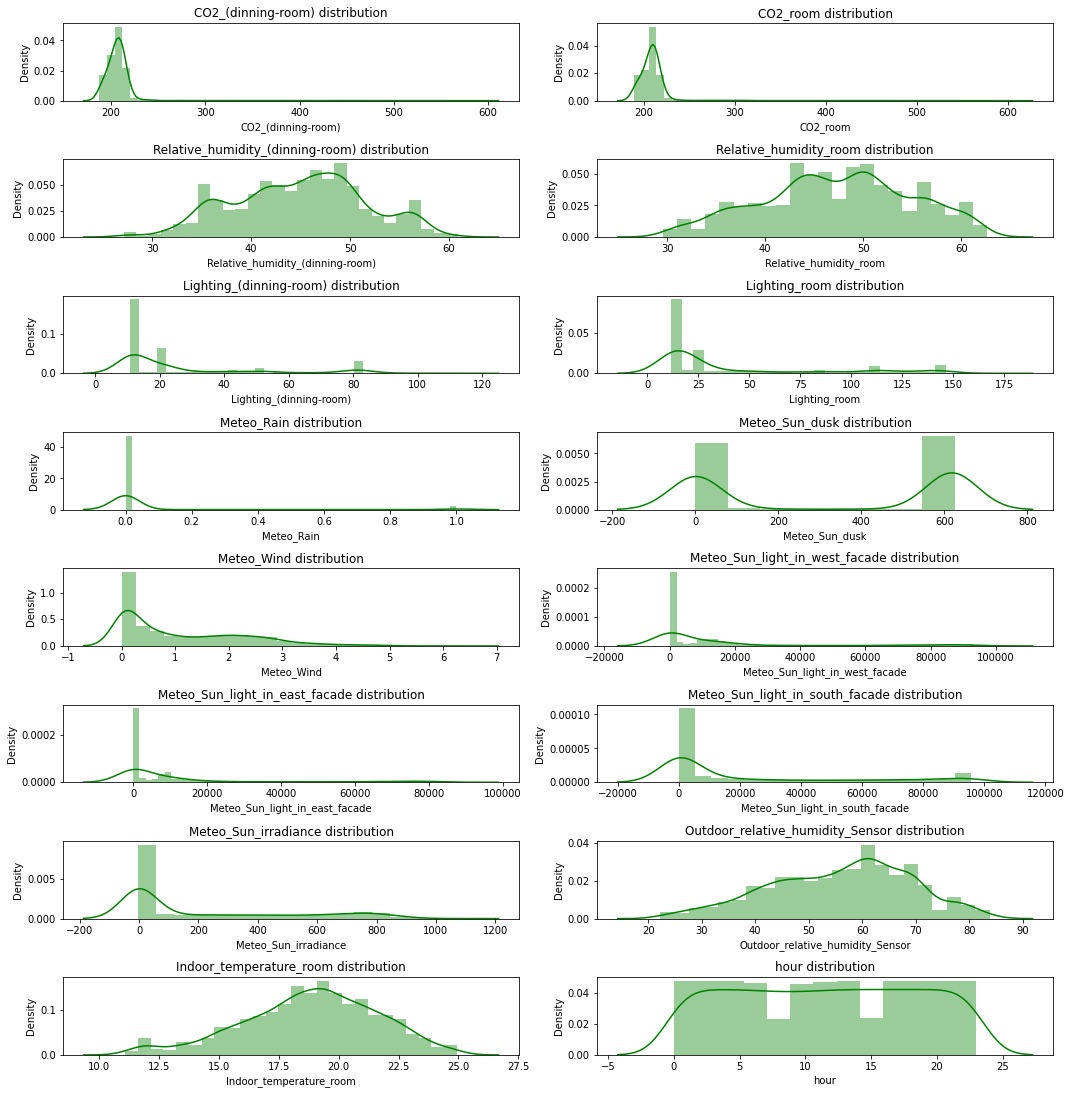

In [12]:
num_feats=[col for col in df.columns if df[col].dtypes != 'object'  and col !='Day_of_the_week' and col != 'Id']
fig=plt.figure(figsize=(15,30))
for i, col in enumerate(num_feats):
    plt.subplot(len(num_feats),2,1*i+1)
    sb.distplot(df[col], color = 'green')
    plt.title(f'{col} distribution')
plt.tight_layout()

##### **<span style = 'color:purple'>Exploring the warning raised by Tukey's rule</span>**
Tukey's rule has found far outliers in CO2_(dinning-room), CO2_room, Lighting_(dinning-room), Meteo_Rain, Meteo_Sun_light_in_west_facade, Meteo_Sun_light_in_east_facade. so we'll look at this in a boxplot.

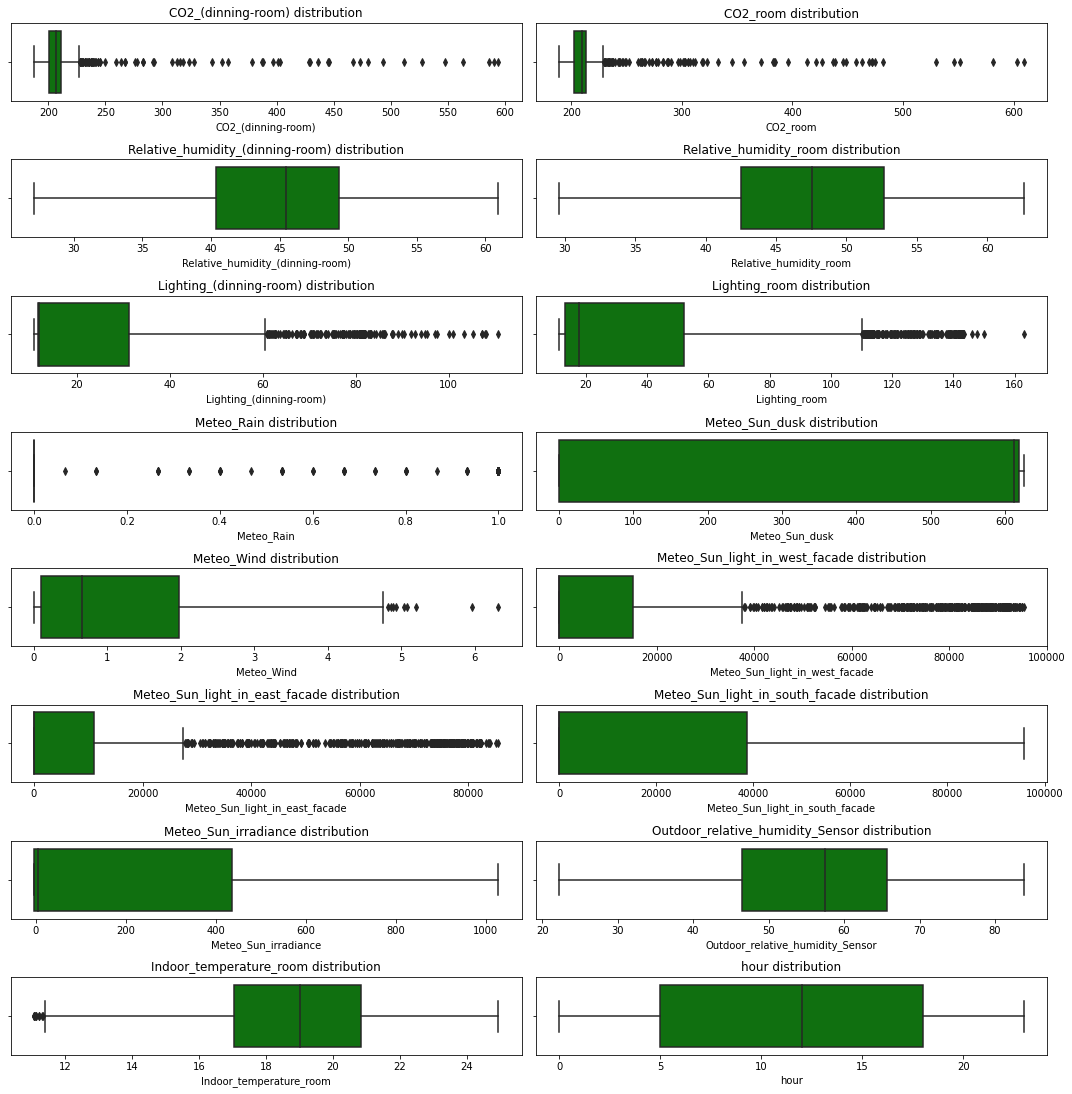

In [13]:
num_feats=[col for col in df.columns if df[col].dtypes != 'object'  and col !='Day_of_the_week' and col != 'Id']
fig=plt.figure(figsize=(15,30))
for i, col in enumerate(num_feats):
    plt.subplot(len(num_feats),2,1*i+1)
    sb.boxplot(df[col], color = 'green')
    plt.title(f'{col} distribution')
plt.tight_layout()

Apply log or square root transformation technique columns contains the outliers to remove outliers.

In [14]:
df_trans = df.copy()
df_trans['CO2_(dinning-room)'] = np.log(df_trans['CO2_(dinning-room)']) # right skewed data -> apply log transform
df_trans['CO2_room'] = np.log(df_trans['CO2_room'])  # right outliers data -> apply log transform
df_trans['Meteo_Rain'] = np.log(df_trans['Meteo_Rain']) # right skewed data -> apply log transform
df_trans['Lighting_(dinning-room)'] = np.log(df_trans['Lighting_(dinning-room)'])  # right outlier data -> apply square root transform
df_trans['Meteo_Sun_light_in_west_facade'] = df_trans['Meteo_Sun_light_in_west_facade']**0.5  # right outlier data -> apply square root transform
df_trans['Meteo_Sun_light_in_east_facade'] = df_trans['Meteo_Sun_light_in_east_facade']**0.5  # right outlier data -> apply square root transform

After trying both log and square root combinations the best results are obtained for Lighting_(dinning-room), Meteo_Sun_light_in_west_facade and Meteo_Sun_light_in_east_facade. The other three CO2_(dinning-room), CO2_room, and Meteo_Rain exhibited no change at all. So its better to remove these three from the training set and retain first three after doing necessary transformation as above.
Plotting them to visualize before and after transformation effects.

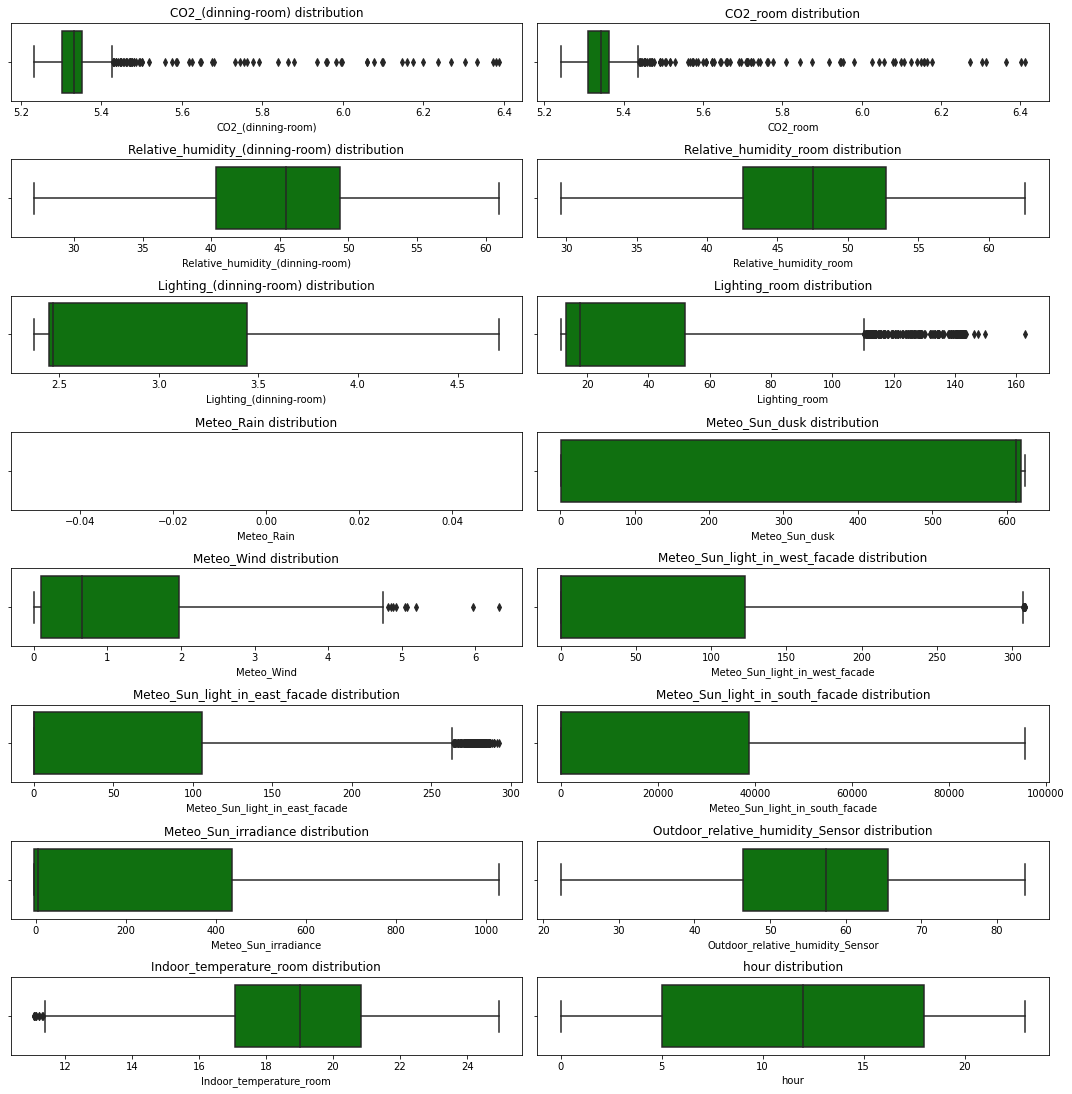

In [15]:
num_feats=[col for col in df.columns if df[col].dtypes != 'object'  and col !='Day_of_the_week' and col != 'Id']
fig=plt.figure(figsize=(15,30))
for i, col in enumerate(num_feats):
    plt.subplot(len(num_feats),2,1*i+1)
    sb.boxplot(df_trans[col], color = 'green')
    plt.title(f'{col} distribution')
plt.tight_layout()

##### **<span style = 'color:purple'>Shapiro-Wilk test for normality</span>**
The Shapiro-Wilk test is a test of normality. It is used to determine whether or not a sample comes from a normal distribution.  A Shapiro-Wilk test uses the following null and alternative hypotheses:

H0: The data is normally distributed.

HA: The data is not normally distributed.

In [16]:
#perform Shapiro-Wilk test for normality
from scipy.stats import shapiro
for col in df.columns:
    print(shapiro(df[col]), 'for', col)

ShapiroResult(statistic=0.9548840522766113, pvalue=1.9836196110532757e-28) for Id
ShapiroResult(statistic=0.3136756420135498, pvalue=0.0) for CO2_(dinning-room)
ShapiroResult(statistic=0.3425375819206238, pvalue=0.0) for CO2_room
ShapiroResult(statistic=0.9889834523200989, pvalue=8.612621520912717e-14) for Relative_humidity_(dinning-room)
ShapiroResult(statistic=0.9853057265281677, pvalue=2.5312137025706473e-16) for Relative_humidity_room
ShapiroResult(statistic=0.6888113021850586, pvalue=0.0) for Lighting_(dinning-room)
ShapiroResult(statistic=0.6827516555786133, pvalue=0.0) for Lighting_room
ShapiroResult(statistic=0.22544991970062256, pvalue=0.0) for Meteo_Rain
ShapiroResult(statistic=0.6555291414260864, pvalue=0.0) for Meteo_Sun_dusk
ShapiroResult(statistic=0.8631851077079773, pvalue=6.305843089461677e-44) for Meteo_Wind
ShapiroResult(statistic=0.6217676401138306, pvalue=0.0) for Meteo_Sun_light_in_west_facade
ShapiroResult(statistic=0.6132000684738159, pvalue=0.0) for Meteo_Sun_li

Since the p-value is less than .05, the null hypothesis of normality is to be rejected. We do have sufficient evidence to say that the sample data does not come from a normal distribution.

##### **<span style = 'color:purple'>Stem-and-Leaf Plot</span>**
A stem-and-leaf plot is a unique plot to visualize distribution of data by splitting up each raw value in a dataset into a stem and a leaf. This chart provides a wealth of information like cumulative frequencies, maximum, minimum, distribution of data using raw values etc. For this, first install stemgraphic library.


In [17]:
pip install stemgraphic

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 244.6 kB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


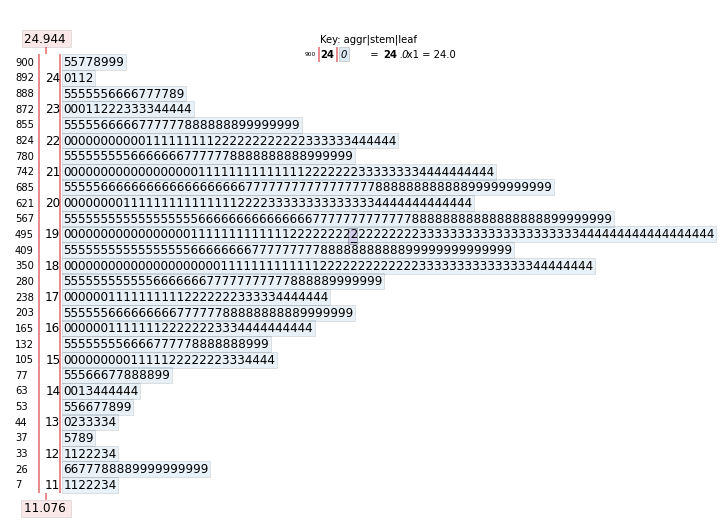

In [18]:
import stemgraphic

#create stem-and-leaf plot
fig, ax = stemgraphic.stem_graphic(df['Indoor_temperature_room'])

The plot can be interpreted as follows:

>1. The number in the bottom red box of the plot reveals the minimum value of indoor temperature (11.076).
>2. The number in the top red box of the chart exhibits the maximum number in the dataset (24.94).
>3. The numbers in the far left display the cumulative frequency of values in the plot. For example, the first row contains 7 cumulative values, the second row contains 26 aggregated values, the third row contains 33 cumulative values, and so on.
>4. The numbers in the middle column display the stems, which starts from 11, 12, and ends in  24 .
>5. The numbers in the far right column display the leaf component. It consists of the rightmost digit of temperature values.


Next step is to analyze for causality amongst these series. The Granger’s Causality test and the Cointegration test can help us with that.
#### **<span style = 'color:purple'>3.1.4 Testing Causation using Granger’s Causality Test</span>**<a id ="Causality"></a>
[<div style="text-align: right"> Back to Table of contents</div>](#Table)

The intuition behind Granger’s Causality Test is that each of the time series in the system influences each other. If this is known, the series with past values of itself can be predicted along with other series in the system.

Using Granger’s Causality Test, it’s possible to select the features responsible for change in behaviour of dependent variables before even building the model.

In Granger’s causality tests all variables are considered simultaneously as predictors (X) and targets (Y).  The null hypothesis is the coefficients of past values in the regression equation is zero. In simpler terms, the past values of time series (X) do not cause the other series (Y). So, if the p-value obtained from the test is lesser than the significance level of 0.05, then the null hypothesis can be rejected safely.

The below code implements the Granger’s Causality test for all possible combinations of the time series in a given dataframe and stores the p-values of each combination in the output matrix.

Check Granger Causality of all possible combinations of the Time series.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.

In [19]:
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(df.drop('Id', axis = 1), variables = df.drop('Id', axis = 1).columns)  

/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:1873: ValueWarning:

covariance of constraints does not have full rank. The number of constraints is 3, but rank is 1

/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:1873: ValueWarning:

covariance of constraints does not have full rank. The number of constraints is 11, but rank is 1



,CO2_(dinning-room)_x,CO2_room_x,Relative_humidity_(dinning-room)_x,Relative_humidity_room_x,Lighting_(dinning-room)_x,Lighting_room_x,Meteo_Rain_x,Meteo_Sun_dusk_x,Meteo_Wind_x,Meteo_Sun_light_in_west_facade_x,Meteo_Sun_light_in_east_facade_x,Meteo_Sun_light_in_south_facade_x,Meteo_Sun_irradiance_x,Outdoor_relative_humidity_Sensor_x,Day_of_the_week_x,Indoor_temperature_room_x,hour_x
CO2_(dinning-room)_y,1.0000,0.0000,0.0077,0.0003,0.0008,0.0000,0.6116,0.4841,0.0225,0.0000,0.0012,0.0000,0.0260,0.2479,0.2852,0.0000,0.3958
CO2_room_y,0.0000,1.0000,0.0010,0.0000,0.0000,0.0000,0.5052,0.5657,0.0189,0.0020,0.0036,0.0014,0.0291,0.4610,0.2832,0.0000,0.7611
Relative_humidity_(dinning-room)_y,0.0042,0.0024,1.0000,0.0000,0.0012,0.0000,0.0510,0.0056,0.0035,0.0000,0.0023,0.0001,0.0000,0.0000,0.0061,0.0016,0.4140
Relative_humidity_room_y,0.5223,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0035,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0001
Lighting_(dinning-room)_y,0.0005,0.0093,0.1519,0.0000,1.0000,0.0000,0.0432,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0004,0.5909,0.0000,0.0000
Lighting_room_y,0.0137,0.0048,0.0945,0.0019,0.0000,1.0000,0.0003,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.6166,0.0000,0.0000
Meteo_Rain_y,0.5561,0.5748,0.2991,0.1951,0.0895,0.0167,1.0000,0.1053,0.0043,0.1884,0.0053,0.0079,0.0037,0.1737,0.0832,0.0358,0.0686
Meteo_Sun_dusk_y,0.4603,0.3896,0.0029,0.0211,0.0000,0.0000,0.3593,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.8864,0.0000,0.0000
Meteo_Wind_y,0.3381,0.3931,0.0511,0.0000,0.0000,0.0000,0.0122,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.3703,0.0000,0.0035
Meteo_Sun_light_in_west_facade_y,0.0000,0.0000,0.0233,0.0102,0.0000,0.0000,0.0003,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.8174,0.0000,0.0003


The rows are the response variable, columns are predictors. The values in the table are the P-Values. P-Values lesser than the significance level (0.05), implies the Null Hypothesis that the coefficients of the corresponding past values is zero, that is, the X does not cause Y can be rejected.

The row are the Response (Y) and the columns are the predictor series (X). If a given p-value is < significance level (0.05), then, the corresponding X series (column) causes the Y (row).
For example, if you take the 0.001 in (row 2, column 3) refers to the p-value of Relative_humidity_(dinning-room)_x causing high CO2_room_x, Whereas, the value 0.0000 in (row 6, column 13), it refers to the p-value of Meteo_Sun_irradiance_x causing Lighting_room_y, which is less that the significance level of 0.05.

So, the null hypothesis can be rejected and conclude that Meteo_Sun_irradiance_x causes Lighting_room_y.

Looking at the P-Values in the above table, you can pretty much observe that all the variables (time series), except 'Day_of_the_week' and 'hour' in the system are interchangeably causing each other. However, hour_x can be considered as a predictor for all other variables except first three variables and the Day_of_the_week variable_y

This makes this system of multi time series a good candidate for using as multivariate models to forecast.

Next, let’s do the Cointegration test. Before that since Relative_humidity_(dinning-room)_x is not a causation factor for Indoor_temperature_room_y it is better to drop it. 

In [20]:
df.drop('Relative_humidity_(dinning-room)', axis = 1, inplace = True)

#### **<span style = 'color:purple'>3.1.5 Johanssen Cointegration Test</span>**<a id ="Cointegration"></a>
[<div style="text-align: right"> Back to Table of contents</div>](#Table)
The basic concept of Cointegration (a technique introduced by Robert Engle and Clive Granger) is that two or more non-stationary times series data are integrated together in a way that they cannot move away from some equilibrium in the long term. Cointegration test helps to establish the presence of a statistically significant connection between two or more time series. When you have two or more time series, and there exists a linear combination of them that has an order of integration (d) less than that of the individual series, then the collection of series is said to be cointegrated. It would imply that a linear combination of the time series can be created, which would result in stationarity.

But, what does Order of integration(d) mean?
Order of integration(d) is nothing but the number of differencing required to make a non-stationary time series stationary.

When two or more time series are cointegrated, it means they have a long run, statistically significant relationship.

This is the basic premise on which multivariate models is based on. So, it’s fairly common to implement the cointegration test before starting to build multivariate models.

Johanssen cointegration test is pretty straightforward to implement using python’s statsmodels, as can be seen below. This is done according to the procedure devised by Soren Johanssen in his [paper (1991)](https://www.econometricsociety.org/publications/econometrica/1991/11/01/estimation-and-hypothesis-testing-cointegration-vectors)to implement this test.

The Johansen test will give the same result even if the order of the time series is reversed, you can try this as an exercise. This test can be used as an order independent way to check for cointegration. This test allows us to check for cointegration between triplets, quadruplets and so on up to 12-time series.

In [21]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen
out_selected = coint_johansen(df[['Meteo_Sun_irradiance', 'Indoor_temperature_room']], 0, 1)
print('Critical values (90%, 95%, 99%) of maximum eigenvalue statistic:\n', out_selected.cvm)
print('Maximum eigenvalue statistic:\n', out_selected.lr2)
print('Eigenvalues of VECM coefficient matrix:\n', out_selected.eig)
print('Critical values (90%, 95%, 99%) of trace statistic:\n', out_selected.cvt)
print('Trace statistic:\n', out_selected.lr2)


Critical values (90%, 95%, 99%) of maximum eigenvalue statistic:
 [[12.2971 14.2639 18.52  ]
 [ 2.7055  3.8415  6.6349]]
Maximum eigenvalue statistic:
 [365.51450299 125.41779507]
Eigenvalues of VECM coefficient matrix:
 [0.12395419 0.0443928 ]
Critical values (90%, 95%, 99%) of trace statistic:
 [[13.4294 15.4943 19.9349]
 [ 2.7055  3.8415  6.6349]]
Trace statistic:
 [365.51450299 125.41779507]


The null hypothesis can be rejected at a 95% confidence level, as the magnitude of the trace statistic is greater than the critical value. The eigen statistics stores the eigenvalues in decreasing order of magnitude, they tell us how strongly cointegrated the series are or how strong is the tendency to mean revert. In our example, the eigen statistic for the null hypothesis can be rejected even at a 99% confidence level, because 125.41779507 is greater than 6.6349.

The null hypothesis was that the time series are not cointegrated, hence when we reject the null hypothesis and accept the alternate hypothesis, we suggest that the series are cointegrated.

In [22]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 36): return str(val).ljust(length)

    # Summary
    print('Name                                 ::  Test Stat  > C(95%)    =>   Signif  \n', '--'*40)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(df.iloc[:, -12: ])

Name                                 ::  Test Stat  > C(95%)    =>   Signif  
 --------------------------------------------------------------------------------
Lighting_room                        ::  2695.2    > 311.1288  =>   True
Meteo_Rain                           ::  1987.03   > 263.2603  =>   True
Meteo_Sun_dusk                       ::  1399.55   > 219.4051  =>   True
Meteo_Wind                           ::  922.3     > 179.5199  =>   True
Meteo_Sun_light_in_west_facade       ::  606.94    > 143.6691  =>   True
Meteo_Sun_light_in_east_facade       ::  419.07    > 111.7797  =>   True
Meteo_Sun_light_in_south_facade      ::  260.55    > 83.9383   =>   True
Meteo_Sun_irradiance                 ::  149.19    > 60.0627   =>   True
Outdoor_relative_humidity_Sensor     ::  70.97     > 40.1749   =>   True
Day_of_the_week                      ::  29.14     > 24.2761   =>   True
Indoor_temperature_room              ::  10.47     > 12.3212   =>   False
hour                                

#### **<span style = 'color:purple'>3.1.6 Cross-correlation plot</span>**<a id ="Cross-correlation"></a>
[<div style="text-align: right"> Back to Table of contents</div>](#Table)

To examine the cross-correlation between for example, Sun Irradiance hours and indoor temperature, which is a process subject to seasonal lag - whereby maximum indoor temperature will lag the period of maximum sunlight irradiance.
The matplotlib xcorr() function can be used to plot the cross correlation between Indoor_temperature_room and other variable's time series to determine if a lag is present, and if so by how many time periods. The cross-correlation is plotted for the data as follows:

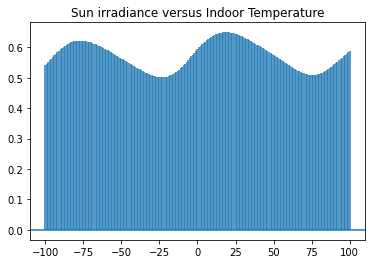

In [23]:
plt.xcorr(df['Indoor_temperature_room'], df['Meteo_Sun_irradiance'], normed=True, usevlines=True, maxlags=100)
plt.title("Sun irradiance versus Indoor Temperature");

In this instance, the strongest correlation between Sun irradiance and Indoor temperature comes lags by approximately 20 days, i.e. this is when the strongest correlation between the two time series is observed. The below xcorrelation plots display the individual influence of parameters such as relative humidity, wind, solar irradiation, lighting etc on indoor temperature.

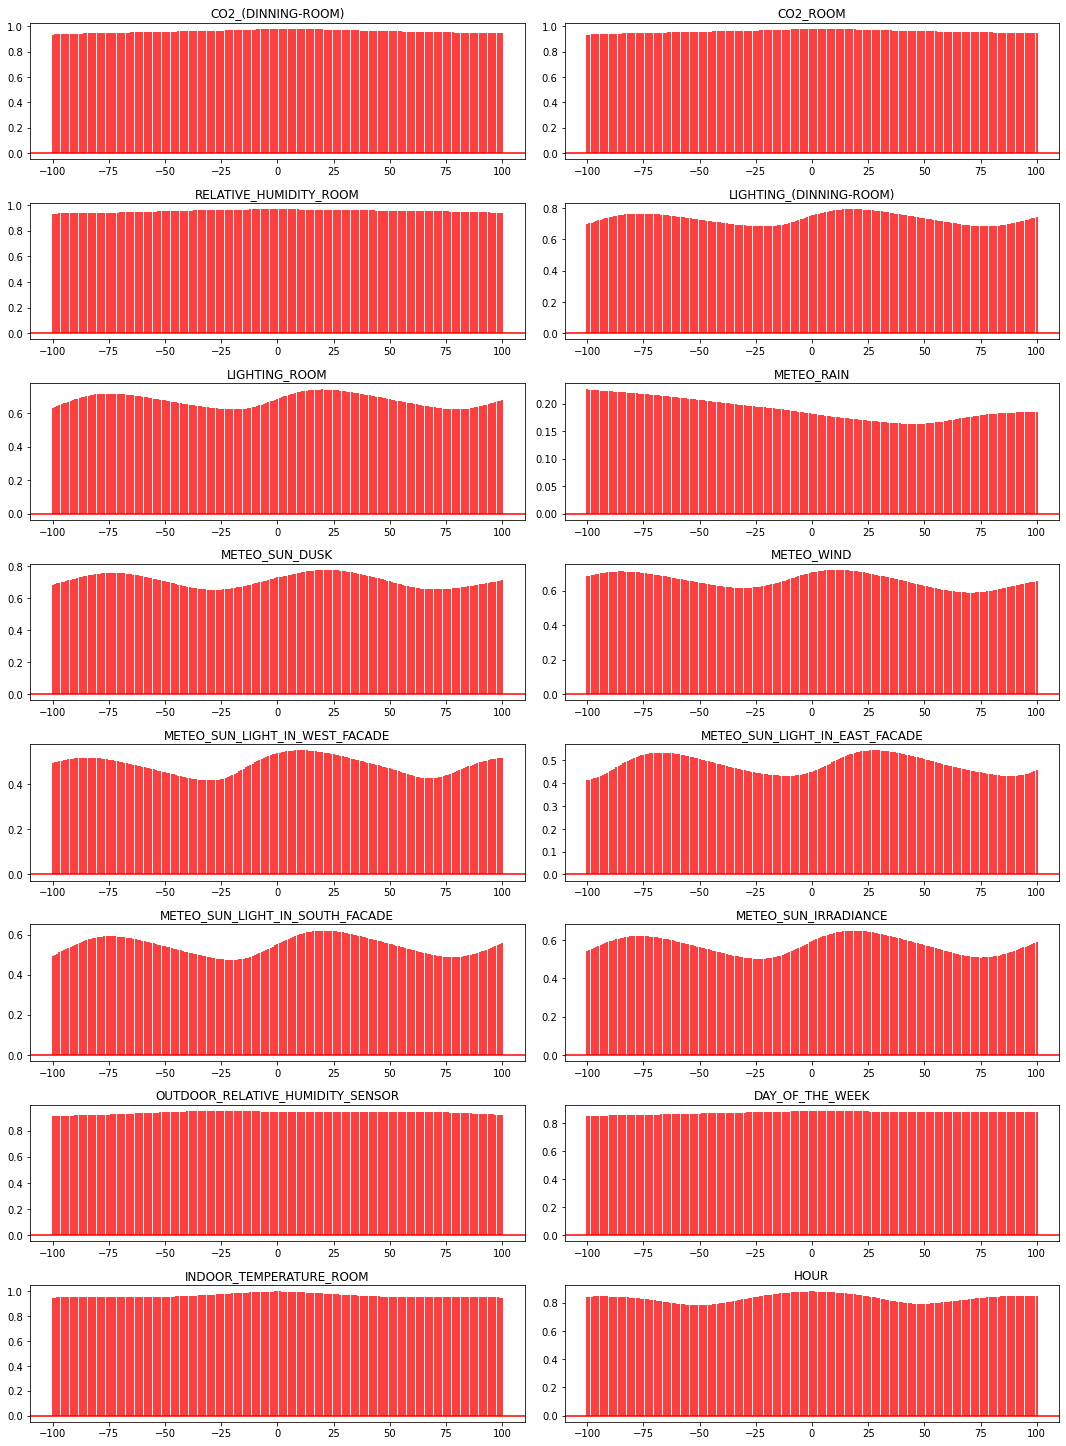

In [24]:
# Numerical features
num_feats=[col for col in df.columns if df[col].dtypes != 'object' and col != 'Id']

# Plot distribution of numerical columns
fig=plt.figure(figsize=(15,40))
for i, col in enumerate(num_feats):
    plt.subplot(len(num_feats),2,1*i+1)
    plt.xcorr(df['Indoor_temperature_room'], df[col], normed=True, usevlines=True, maxlags=100, color = 'red')
    plt.title(col.upper())
    
fig.tight_layout()
plt.show()

Data with a sine or cosine-like wave indicate seasonality, which repeat itself periodically. To know more about this, define a function to make lags using shift method and then call the function on each variable to make any desirable number of lags.

Make lags of some of the numerical columns and check their corresponding correlation with 'Indoor_temperature_room' to find the lag that has the most impact on temperature.

In [25]:
def make_lags(ts, lags, start):
    return pd.concat(
        {
            f'y_lag_{i}': ts.shift(i)
            for i in range(start, lags + 1)
        },
        axis=1)
X = make_lags(df['Meteo_Sun_irradiance'], lags=25, start = 15)
X

,y_lag_15,y_lag_16,y_lag_17,y_lag_18,y_lag_19,y_lag_20,y_lag_21,y_lag_22,y_lag_23,y_lag_24,y_lag_25
2012-03-13 11:45:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-03-13 12:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-03-13 12:15:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-03-13 12:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-03-13 12:45:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2012-04-11 05:30:00,-3.64267,-3.70800,-3.64267,-3.51200,-3.70800,-3.57733,-3.83867,-3.90400,-3.83867,-3.64267,-3.77333
2012-04-11 05:45:00,-3.83867,-3.64267,-3.70800,-3.64267,-3.51200,-3.70800,-3.57733,-3.83867,-3.90400,-3.83867,-3.64267
2012-04-11 06:00:00,-3.70800,-3.83867,-3.64267,-3.70800,-3.64267,-3.51200,-3.70800,-3.57733,-3.83867,-3.90400,-3.83867
2012-04-11 06:15:00,-3.70800,-3.70800,-3.83867,-3.64267,-3.70800,-3.64267,-3.51200,-3.70800,-3.57733,-3.83867,-3.90400


In [26]:
X['Indoor_temperature_room'] = df['Indoor_temperature_room']
X.iloc[25:, :].corr()['Indoor_temperature_room'].sort_values(ascending = False)[0:5]

Indoor_temperature_room    1.000000
y_lag_19                   0.586102
y_lag_18                   0.585009
y_lag_20                   0.584844
y_lag_17                   0.581405
Name: Indoor_temperature_room, dtype: float64

In [27]:
z = make_lags(df['Lighting_room'], lags=25, start = 15)
z = z.fillna(0)
z['Indoor_temperature_room'] = df['Indoor_temperature_room']
z.iloc[25:, :].corr()['Indoor_temperature_room'].sort_values(ascending = False)[0:5]

Indoor_temperature_room    1.000000
y_lag_21                   0.536779
y_lag_20                   0.536029
y_lag_22                   0.535330
y_lag_19                   0.532963
Name: Indoor_temperature_room, dtype: float64

In [28]:
z = make_lags(df['Meteo_Wind'], lags=50, start = 1)
z = z.fillna(0)
z['Indoor_temperature_room'] = df['Indoor_temperature_room']
abs(z.iloc[25:, :].corr()['Indoor_temperature_room']).sort_values(ascending = False)[0:5]

Indoor_temperature_room    1.000000
y_lag_12                   0.365277
y_lag_11                   0.364461
y_lag_13                   0.364135
y_lag_10                   0.361828
Name: Indoor_temperature_room, dtype: float64

In [29]:
hr = make_lags(df['hour'], lags=25, start=1)
hr = hr.fillna(0)
hr['Indoor_temperature_room'] = df['Indoor_temperature_room']
hr.corr()['Indoor_temperature_room'].sort_values(ascending = False)[0:5]

Indoor_temperature_room    1.000000
y_lag_1                    0.416555
y_lag_2                    0.413920
y_lag_3                    0.409978
y_lag_4                    0.404769
Name: Indoor_temperature_room, dtype: float64

In [30]:
humidity = make_lags(df['Outdoor_relative_humidity_Sensor'], lags=25, start = 1)
humidity = humidity.fillna(0)
humidity['Indoor_temperature_room'] = df['Indoor_temperature_room']
abs(humidity.corr()['Indoor_temperature_room']).sort_values(ascending = False)[0:5]

Indoor_temperature_room    1.000000
y_lag_6                    0.568856
y_lag_7                    0.568532
y_lag_5                    0.568204
y_lag_8                    0.567245
Name: Indoor_temperature_room, dtype: float64

In [31]:
df_lag = df.copy()
df_lag['Meteo_Sun_irradiance'] = df_lag['Meteo_Sun_irradiance'].shift(19)
df_lag['Lighting_room'] = df_lag['Lighting_room'].shift(21)
df_lag['Outdoor_relative_humidity_Sensor'] = df_lag['Outdoor_relative_humidity_Sensor'].shift(6)
df_lag['Meteo_Wind'] = df_lag['Meteo_Wind'].shift(12)

corr = df_lag.drop(['Id'], axis = 1).corr()
abs(corr['Indoor_temperature_room']).sort_values(ascending = False)[0:10]

Indoor_temperature_room             1.000000
Meteo_Sun_irradiance                0.588970
Outdoor_relative_humidity_Sensor    0.581000
Lighting_room                       0.538869
Relative_humidity_room              0.417901
hour                                0.417876
Meteo_Wind                          0.369261
Meteo_Sun_light_in_west_facade      0.335288
Meteo_Sun_light_in_east_facade      0.269034
Meteo_Rain                          0.262621
Name: Indoor_temperature_room, dtype: float64

In [32]:
print(df[['Lighting_room', 'Meteo_Sun_irradiance']].corr())

                      Lighting_room  Meteo_Sun_irradiance
Lighting_room              1.000000              0.932237
Meteo_Sun_irradiance       0.932237              1.000000


* After applying lag, it is clearly visible that Meteo_Sun_irradiance is the most correlated with Indoor temperature.
* This is then followed by Outdoor_relative_humidity_Sensor,
* and thenby 'Lighting_room', which is almost perfectly collinear to sun irradiance (0.92). So either one should be selected and it is better to drop Lighting from the list because it is the direct effect of the irradiance.
* Next in the list is 'Relative_humidity_room'
* and 'hour' also have moderate correlation with Indoor temperature.

### **<span style = 'color:brown'>3.2. Model Estimation and Evaluation</span>**<a id = 'Estimation'></a>
[<div style="text-align: right"> Back to Table of contents</div>](#Table)

#### **<span style = 'color:purple'>3.2.1 Estimation of non-seasonal order (d): Check for Stationarity and Make the Time Series Stationary</span>**<a id ="Stationarity"></a>
[<div style="text-align: right"> Back to Table of contents</div>](#Table)

A stationary time series is one in which the properties — mean, variance and covariance, do not vary with time. Since the VAR model requires the time series you want to forecast to be stationary, it is customary to check all the time series in the system for stationarity and make sure their means and variances are constant over time and do not show any trending behaviour.

So, how to test for stationarity? 

There is a series of statistical tests and the popular ones are:

* Augmented Dickey-Fuller Test (ADF Test)
* KPSS test
* Philip-Perron test

Another very common practise is to plot a series, as done before and check if it moves around a constant mean value, i.e. a horizontal line. If this is the case, it is likely to be stationary. 

At this point it should be mentioned that even if two time series are not stationary, a special combination of them can still be stationary. This phenomenon is called cointegration and so-called (vector) error correction models (VECM) can be used to analyse it. 

##### **Augmented Dickey-Fuller Test (ADF Test)**
Let’s use the ADF test for our purpose.

By the way, if a series is found to be non-stationary, you make it stationary by differencing the series once and repeat the test again until it becomes stationary.

Since, differencing reduces the length of the series by 1 and since all the time series has to be of the same length, you need to difference all the series in the system if you choose to difference at all.
Got it?

Let’s implement the ADF Test.

First, we implement a nice function (adfuller_test()) that writes out the results of the ADF test for any given time series and implement this function on each series one-by-one.

In [33]:
from statsmodels.tsa.stattools import adfuller
def ADF_test(series, column_name):
    #Ho: Time Series is Non-Stationary
    #Ha: Time Series is Stationary
    print (f'Results of Dickey-Fuller Test for column: {column_name}')
    dftest = adfuller(series, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','No Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    if dftest[1] <= 0.05:
        print("Conclusion:====>")
        print("Reject the null hypothesis")
        print("Data is stationary")
    else:
        print("Conclusion:====>")
        print("Fail to reject the null hypothesis")
        print("Data is non-stationary")

Call the ADF_test() on each series.

In [34]:
df2 = df[['Meteo_Sun_irradiance', 'hour', 'Outdoor_relative_humidity_Sensor', 'Indoor_temperature_room']]
# ADF Test on each column
for name, column in df2.iteritems():
    ADF_test(df2[name], name)
    print('\n')

Results of Dickey-Fuller Test for column: Meteo_Sun_irradiance
Test Statistic                -1.340825e+01
p-value                        4.426169e-25
No Lags Used                   1.200000e+01
Number of Observations Used    2.751000e+03
Critical Value (1%)           -3.432729e+00
Critical Value (5%)           -2.862591e+00
Critical Value (10%)          -2.567330e+00
dtype: float64
Conclusion:====>
Reject the null hypothesis
Data is stationary


Results of Dickey-Fuller Test for column: hour
Test Statistic                -1.128312e+01
p-value                        1.439741e-20
No Lags Used                   2.700000e+01
Number of Observations Used    2.736000e+03
Critical Value (1%)           -3.432742e+00
Critical Value (5%)           -2.862597e+00
Critical Value (10%)          -2.567333e+00
dtype: float64
Conclusion:====>
Reject the null hypothesis
Data is stationary


Results of Dickey-Fuller Test for column: Outdoor_relative_humidity_Sensor
Test Statistic                   -4.777

##### **KPSS Test for Stationarity**
KPSS test, short for, Kwiatkowski-Phillips-Schmidt-Shin, is a statistical test to check for stationarity of a series around a deterministic trend. Like ADF test, the KPSS test is also commonly used to analyse the stationarity of a series. However, it has couple of key differences compared to the ADF test in function and in practical usage. Therefore, is not safe to just use them interchangeably. 

A key difference from ADF test is the null hypothesis of the KPSS test is that the series is stationary. So practically, the interpretaion of p-value is just the opposite to each other. That is, if p-value is < signif level (say 0.05), then the series is non-stationary. Whereas in ADF test, it would mean the tested series is stationary.

In python, the statsmodel package provides a convenient implementation of the KPSS test.

To implement the KPSS test, we’ll use the kpss function from the statsmodel. The code below implements the test and prints out the returned outputs and interpretation from the result.

In [35]:
# KPSS test
from statsmodels.tsa.stattools import kpss
def KPSS_test(series, column_name): 
    #Ho: Time Series is TStationary
    #Ha: Time Series is Non-Stationary
    print (f'Results of Kwiatkowski-Phillips-Schmidt-Shin (KPSS) Test for mean stationarity for column: {column_name}')
    #statistic, p_value, n_lags, critical_values = kpss(series)
    KPSS_results = kpss(series)
    kpssoutput = pd.Series(KPSS_results[0:3], index=['Test Statistic','p-value','No Lags Used'])
    # Format Output
    for key,value in KPSS_results[3].items():
       kpssoutput['Critical Value (%s)'%key] = value
    print (kpssoutput)
    if KPSS_results[1] <= 0.05:
        print("Conclusion:====>")
        print("Reject the null hypothesis")
        print("Data is non-stationary")
    else:
        print("Conclusion:====>")
        print("Fail to reject the null hypothesis")
        print("Data is stationary")

A major difference between KPSS and ADF tests is the capability of the KPSS test to check for stationarity in the ‘presence of a deterministic trend’. What that effectively means to us is, the test may not necessarily reject the null hypothesis (that the series is stationary) even if a series is steadily increasing or decreasing.

The word ‘deterministic’ implies the slope of the trend in the series does not change permanently. That is, even if the series goes through a shock, it tends to regain its original path. There appears to be a steady increasing trend overall in all plots above. So, we could expect that this series is stationary around the trend.

Applying the KPSS test . .

In [36]:
# KPSS Test on each column
for name, column in df2.iteritems():
    KPSS_test(df2[name], name)
    print('\n')

Results of Kwiatkowski-Phillips-Schmidt-Shin (KPSS) Test for mean stationarity for column: Meteo_Sun_irradiance
Test Statistic            0.013993
p-value                   0.100000
No Lags Used             30.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64
Conclusion:====>
Fail to reject the null hypothesis
Data is stationary


Results of Kwiatkowski-Phillips-Schmidt-Shin (KPSS) Test for mean stationarity for column: hour
Test Statistic            0.006544
p-value                   0.100000
No Lags Used             29.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64
Conclusion:====>
Fail to reject the null hypothesis
Data is stationary


Results of Kwiatkowski-Phillips-Schmidt-Shin (KPSS) Test for mean stationarity for column: Outdoor_relative_humidity_Sensor
Te

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.




The test says the p-value is significant (with p_value < 0.05) and hence, the null hypothesis (series is stationary) can be rejected and derive that the series is NOT stationary.

But according to the definition of KPSS, it should have not have rejected the null, because of the ‘stationarity around a deterministic trend’. It is because by default, it tests for stationarity around a ‘mean’ only.

##### **KPSS test around a deterministic trend**
In KPSS test, to turn ON the stationarity testing around a trend, pass the regression='ct' parameter to the kpss.

In [37]:
# KPSS test
from statsmodels.tsa.stattools import kpss
def KPSS_test(series, column_name): 
    #Ho: Time Series is Trend Stationary
    #Ha: Time Series is Non-Trend Stationary
    print (f'Results of Kwiatkowski-Phillips-Schmidt-Shin (KPSS) Test for trend stationarity for column: {column_name}')
    #statistic, p_value, n_lags, critical_values = kpss(series)
    KPSS_results = kpss(series, regression='ct')
    kpssoutput = pd.Series(KPSS_results[0:3], index=['Test Statistic','p-value','No Lags Used'])
    # Format Output
    for key,value in KPSS_results[3].items():
       kpssoutput['Critical Value (%s)'%key] = value
    print (kpssoutput)
    if KPSS_results[1] <= 0.05:
        print("Conclusion:====>")
        print("Reject the null hypothesis")
        print("Data is non-stationary")
    else:
        print("Conclusion:====>")
        print("Fail to reject the null hypothesis")
        print("Data is stationary")

In [38]:
# KPSS Test on each column
for name, column in df2.iteritems():
    KPSS_test(df2[name], name)
    print('\n')

Results of Kwiatkowski-Phillips-Schmidt-Shin (KPSS) Test for trend stationarity for column: Meteo_Sun_irradiance
Test Statistic            0.013992
p-value                   0.100000
No Lags Used             30.000000
Critical Value (10%)      0.119000
Critical Value (5%)       0.146000
Critical Value (2.5%)     0.176000
Critical Value (1%)       0.216000
dtype: float64
Conclusion:====>
Fail to reject the null hypothesis
Data is stationary


Results of Kwiatkowski-Phillips-Schmidt-Shin (KPSS) Test for trend stationarity for column: hour
Test Statistic            0.004572
p-value                   0.100000
No Lags Used             29.000000
Critical Value (10%)      0.119000
Critical Value (5%)       0.146000
Critical Value (2.5%)     0.176000
Critical Value (1%)       0.216000
dtype: float64
Conclusion:====>
Fail to reject the null hypothesis
Data is stationary


Results of Kwiatkowski-Phillips-Schmidt-Shin (KPSS) Test for trend stationarity for column: Outdoor_relative_humidity_Sensor

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.




The ADF test with p-value of < 0.01 and KPSS test with p-value of >0.1 proved the stationarity of the temperature series around mean but non-stationarity around deterministic trend. Since the series is ADF stationary, differencing can be avoided. 

#### **<span style = 'color:purple'>3.2.2 Estimation of Non-seasonal orders (p, d, q) by hyper parameter grid search tuning</span>**<a id ="Non-seasonal"></a>
[<div style="text-align: right"> Back to Table of contents</div>](#Table)
**Estimation of parameters using AIC, BIC, FPE and HQIC**

The procedure for choosing these models relies on choosing the model with the minimum AIC, BIC, FPE and HQIC. To select the right lag order of the model, iteratively fit increasing orders of the model and pick the order that gives a model with least AIC. 

The Akaike information criterion (AIC) is a metric that is used to compare the fit of different regression models. Once you’ve fit several regression models, you can compare the AIC value of each model. The model with the lowest AIC offers the best fit. The absolute value of the AIC value is not important.  It can be positive or negative.The lower the value for AIC, the better the fit of the model. There is no value for AIC that can be considered “good” or “bad” because we simply use AIC as a way to compare regression models. The AIC value is a useful way to determine which regression model fits a dataset the best among a list of potential models, but it doesn’t actually quantify how well the model fits the data. For example, a particular regression model might have the lowest AIC value among a list of potential models, but it may still be a poor fitting model. One potential strategy for choosing the “best” regression model among several potential models is as follows: First, identify the model with the lowest AIC value. Then, fit this regression model to the data and calculate the Mallows’ Cp and adjusted R-squared of the model to quantify how well it actually fits the data.

Though the usual practice is to look at the AIC, other best fit comparison estimates of Bayesian Information Criterion (BIC) and Hannan-Quinn Information Criterion (HQIC) can also be used.

**Split the Series into Training and Testing Data**

Splitting the dataset into training and test data. separate the last 20% of the data as test data and the remaining part as training data. 

The model will be fitted on df_train and then used to forecast the next 20% observations. These forecasts will be compared against the actuals present in test data.

To do the comparisons, we will use multiple forecast accuracy metrics, as seen later in this article.

In [39]:
size = int(len(df2) * 0.20)
df_train, df_test = df2[0:-size], df2[-size:]

# Check size
print(df_train.shape)  
print(df_test.shape)  

(2212, 4)
(552, 4)


In [40]:
import warnings
warnings.simplefilter(action='ignore', category=Warning)

from statsmodels.tsa.arima.model import ARIMA
best_score, best_order = np.inf, None
for i in [4,5,6,7,8]:
    for j in [0, 1]:
        for k in [0, 1,2,3]:
            model = ARIMA(df_train['Indoor_temperature_room'], freq = '15T', order=(i,j,k)).fit()
            model_aic = model.aic
            if model_aic < best_score:
                best_score = model_aic
                best_order = (i, j, k)
                
print('aic: {:6.5f} | order: {}'.format(best_score, best_order)) 

aic: -6932.09388 | order: (8, 1, 2)


```python
# 1st difference
df_train_differenced = df_train.diff().dropna()
from statsmodels.tsa.arima.model import ARIMA
for i in [4,7,8,9]:
  for j in [0, 1]:
    for k in [0, 1]:
      model = ARIMA(df_train_differenced['Indoor_temperature_room'], order = (i, j, k))
      result = model.fit()
      print('Lag Order =', i, j, k)
      print('AIC : ', result.aic)
      print('BIC : ', result.bic)
      #print('FPE : ', result.fpe)
      print('HQIC: ', result.hqic, '\n')
```

Manual fine tuning of parameters can be done by examining lag plot, PACF and ACF.

#### **<span style = 'color:purple'>3.2.3 Lag plot</span>**<a id ="Lagplot"></a>
[<div style="text-align: right"> Back to Table of contents</div>](#Table)
A lag plot to compare indoor room temperature autocorrelationfrom each observation in the dataset against the one from a previous observation.

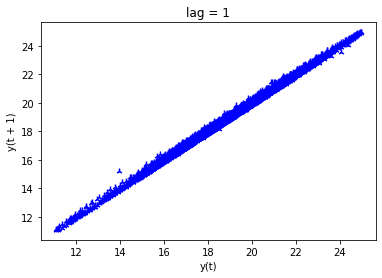

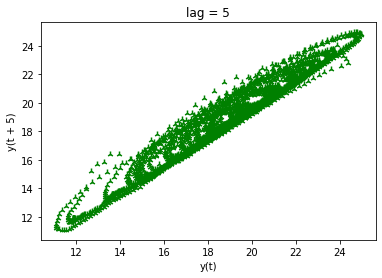

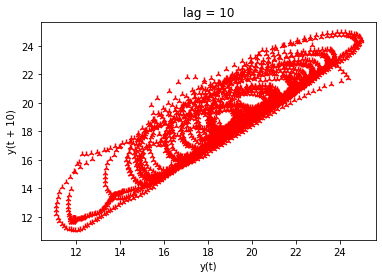

In [41]:
#from pandas import plotting
#plotting.lag_plot(df['Indoor_temperature_room'], lag=1, marker='2', c='blue')

from pandas.plotting import lag_plot
plt.figure()
lag_plot(df['Indoor_temperature_room'], lag=1, marker='2', c='blue')
plt.title('lag = 1')
plt.figure()
lag_plot(df['Indoor_temperature_room'], lag=5, marker='2', c='green')
plt.title('lag = 5');
plt.figure()
lag_plot(df['Indoor_temperature_room'], lag=10, marker='2', c='red')
plt.title('lag = 10');

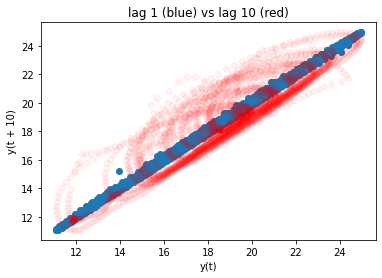

In [42]:
from pandas import plotting
plt.figure()
plotting.lag_plot(df['Indoor_temperature_room'], lag=1)
plotting.lag_plot(df['Indoor_temperature_room'], lag=10, c= 'red', alpha =0.05)
plt.title('lag 1 (blue) vs lag 10 (red)');

If the plot shows a linear pattern, it suggests autocorrelation is present. A positive linear trend (i.e. going upwards from left to right) is suggestive of positive autocorrelation and the tighter the data is clustered around the diagonal, the more autocorrelation is present; perfectly autocorrelated data will cluster in a single diagonal line. Since the lag plot is linear, the underlying structure is of the autoregressive in nature. The linear shape to the plot suggests that an autoregressive model with 1 lag is probably the best choice for this data. Almost the entire values are concentrated on the diagonal in lag plot, it suggests a strong autocorrelation.
The plots overlapped on top of each other shows the difference in dispersion of points on increasing the lags.

#### **<span style = 'color:purple'>3.2.4 Partial Autocorrelation Plot of the Indoor Temperatures</span>**<a id ="PACF-Plot"></a>
[<div style="text-align: right"> Back to Table of contents</div>](#Table)

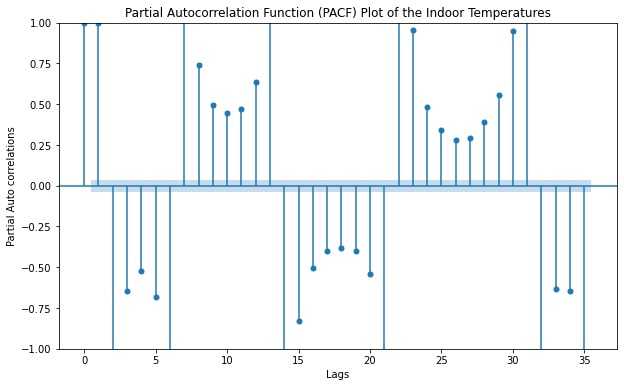

In [43]:
from statsmodels.graphics.tsaplots import plot_pacf
plt.rc("figure", figsize=(10,6))
plot_pacf(df['Indoor_temperature_room'], title = "Partial Autocorrelation Function (PACF) Plot of the Indoor Temperatures");
plt.xlabel('Lags')
plt.ylabel('Partial Auto correlations')
plt.show();

#### **<span style = 'color:purple'>3.2.5. Estimation of non-seasonal order (q): Autocorrelation Plot of the Indoor Temperatures</span>**<a id ="q"></a>
[<div style="text-align: right"> Back to Table of contents</div>](#Table)

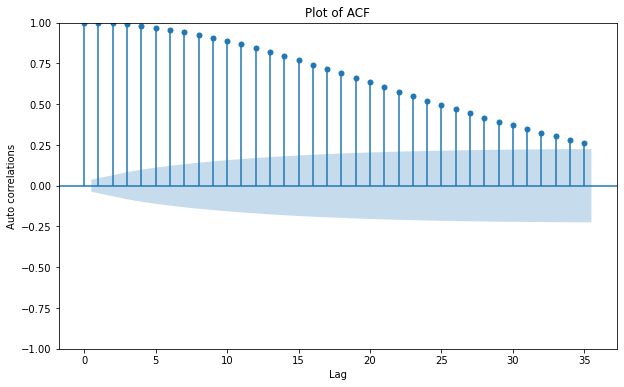

In [44]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(df['Indoor_temperature_room'])
plt.xlabel('Lag')
plt.ylabel('Auto correlations')
plt.title('Plot of ACF')
plt.show()

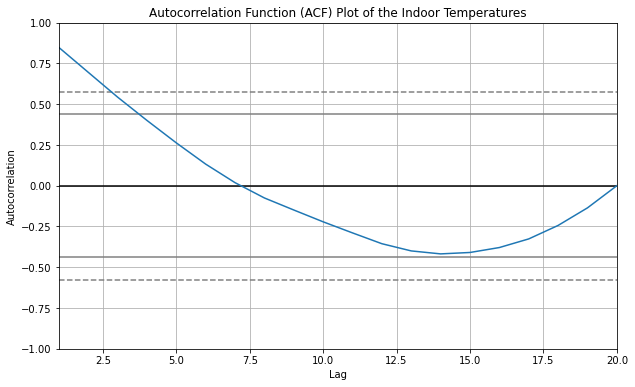

In [45]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(df['Indoor_temperature_room'].head(20))
plt.title("Autocorrelation Function (ACF) Plot of the Indoor Temperatures");

The above plot shows the ACF and PACF of the indoor temperature series with 95% confidence limits. From the correlogram, most of the spikes in both the ACF and the PACF were observed to be outside the confidence limits. Also the ACF shows a cyclic or seasonal movement/variation of the correlations, hence shows sinusoidal waves and oscillation movements. Also the ACF shows slow decay of the spikes indicating that the series has no trend and hence stationary.

The lag plots indicate that the relationship of Indoor temperature to its lags is mostly linear, while the partial autocorrelation suggests the dependence can be captured efficiently using lags 1, 2, 3, 7, 8 etc. It is better to settle with a lag of 8 for building this model. ACF recommends a q value of 2. This can be evaluated further in the following analysis steps.

Since the lower the value for AIC, the better the fit of the model, the model with the least AIC, BIC and HQIC is ARIMA (8,1,2) indicating that ARIMA (8,1,2) is the best model for predicting the indoor temperature.

In [46]:
model = ARIMA(df_train['Indoor_temperature_room'], freq = '15T', order = (8, 1, 2))
result = model.fit()
print('AIC : ', result.aic)
print('BIC : ', result.bic)
#print('FPE : ', result.fpe)
print('HQIC: ', result.hqic)
result.summary()

AIC :  -6932.093878072506
BIC :  -6869.380676083075
HQIC:  -6909.183602016645


<class 'statsmodels.iolib.summary.Summary'>
"""
                                  SARIMAX Results                                  
===================================================================================
Dep. Variable:     Indoor_temperature_room   No. Observations:                 2212
Model:                      ARIMA(8, 1, 2)   Log Likelihood                3477.047
Date:                     Wed, 20 Jul 2022   AIC                          -6932.094
Time:                             08:07:10   BIC                          -6869.381
Sample:                         03-13-2012   HQIC                         -6909.184
                              - 04-05-2012                                         
Covariance Type:                       opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6784      0.022     30.650      0.000       0.635       0.722
ar.L2          1.0539      0.034     30.684      0.000       0.987       1.121
ar.L3         -0.4800      0.018    -27.068      0.000      -0.515      -0.445
ar.L4         -0.1363      0.009    -15.662      0.000      -0.153      -0.119
ar.L5         -0.1482      0.022     -6.874      0.000      -0.190      -0.106
ar.L6          0.1045      0.018      5.656      0.000       0.068       0.141
ar.L7         -0.0493      0.021     -2.346      0.019      -0.090      -0.008
ar.L8         -0.0405      0.018     -2.207      0.027      -0.076      -0.005
ma.L1          0.0260      0.023      1.144      0.253      -0.019       0.071
ma.L2         -0.9670      0.023    -41.277      0.000      -1.013      -0.921
sigma2         0.0025   1.53e-05    164.106      0.000       0.002       0.003
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):            459718.98
Prob(Q):                              0.87   Prob(JB):                         0.00
Heteroskedasticity (H):               0.55   Skew:                             2.11
Prob(H) (two-sided):                  0.00   Kurtosis:                        73.52
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### **<span style = 'color:brown'>3.3 Model Checking (Goodness of fit)/Model Verification/Model Diagnostics</span>**<a id = 'Diagnostics'></a>
[<div style="text-align: right"> Back to Table of contents</div>](#Table)

#### **<span style = 'color:purple'>3.3.1 Check for Serial Correlation of Residuals (Errors) using Durbin Watson Statistic</span>**<a id ="DWStatistic"></a>
[<div style="text-align: right"> Back to Table of contents</div>](#Table)

In time series modeling, the selection of a best model fit to the data is directly related to whether residual analysis is performed well. One of the assumptions of ARIMA model is that, for a good model, the residuals must follow a white noise process. That is, the residuals have zero mean, constant variance and also uncorrelated. Serial correlation of residuals is used to check if there is any leftover pattern in the residuals (errors). If there is any correlation left in the residuals, then, there is some pattern in the time series that is still left to be explained by the model. In that case, the typical course of action is to either increase the order of the model or induce more predictors into the system or look for a different algorithm to model the time series.

So, checking for serial correlation is to ensure that the model is sufficiently able to explain the variances and patterns in the time series. A common way of checking for serial correlation of errors can be measured using the Durbin Watson’s Statistic.

**[The Durbin-Watson Test](https://www.statology.org/durbin-watson-test/)**
One of the main assumptions in linear regression is that there is no correlation between consecutive residuals. When this assumption is violated, the standard errors of the coefficients in a regression model are likely to be underestimated which means predictor variables are more likely to be deemed statistically significant when they’re actually not. One way to determine if this assumption is met is to perform a Durbin-Watson test, which is used to detect the presence of autocorrelation in the residuals of a regression.

H0 (null hypothesis): There is no correlation among the residuals.

HA (alternative hypothesis): The residuals are autocorrelated.

The value of this statistic can vary between 0 and 4. The closer it is to the value 2, then there is no significant serial correlation. The closer to 0, there is a positive serial correlation, and the closer it is to 4 implies negative serial correlation.

* d = 2 indicates no autocorrelation
* d < 2 indicates positive serial correlation
* d > 2 indicates negative serial correlation

**What to Do if Autocorrelation is Detected?**

If you reject the null hypothesis of the Durbin-Watson test and conclude that autocorrelation is present in the residuals, then you have a few different options to correct this problem if you deem it to be serious enough:

* For positive serial correlation, consider adding lags of the dependent and/or independent variable to the model.
* For negative serial correlation, check to make sure that none of your variables are overdifferenced.

In [47]:
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(result.resid)
out

0.9849591947289639

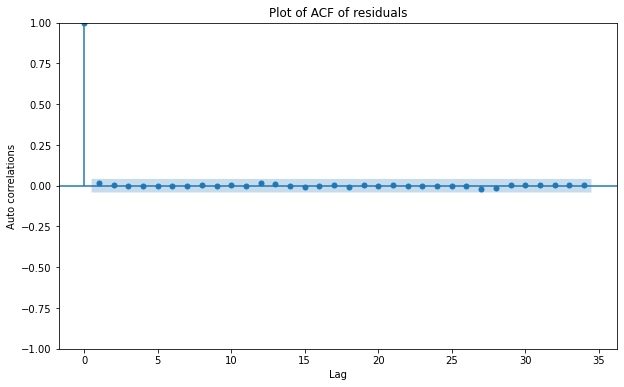

In [48]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(result.resid)
plt.xlabel('Lag')
plt.ylabel('Auto correlations')
plt.title('Plot of ACF of residuals')
plt.show()

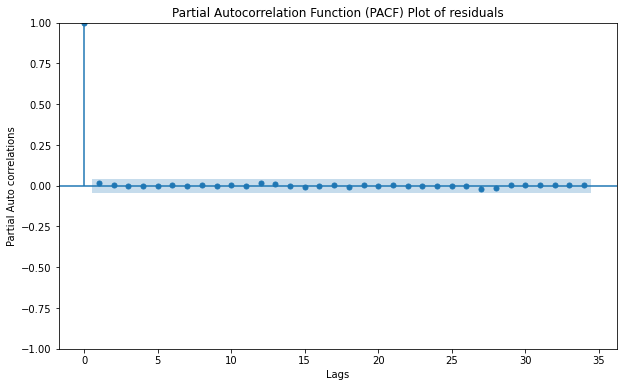

In [49]:
from statsmodels.graphics.tsaplots import plot_pacf
plt.rc("figure", figsize=(10,6))
plot_pacf(result.resid, title = "Partial Autocorrelation Function (PACF) Plot of residuals");
plt.xlabel('Lags')
plt.ylabel('Partial Auto correlations')
plt.show();

The serial correlation seems quite alright. Let’s proceed with the prediction and validation.
#### **<span style = 'color:purple'>3.3.2 Prediction / Forecast with ARIMA model using statsmodels</span>**<a id ="Prediction"></a>
[<div style="text-align: right"> Back to Table of contents</div>](#Table)

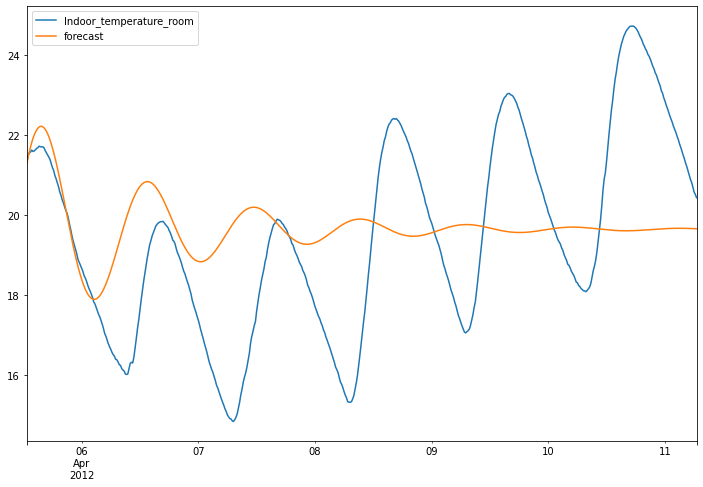

In [50]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(df_train['Indoor_temperature_room'], order = (8, 1, 2))
model = model.fit()
df_test['forecast']=model.predict(start=len(df_train),end=len(df2)-1,dynamic=True)

df_test[['Indoor_temperature_room','forecast']].plot(figsize=(12,8));

#### **<span style = 'color:purple'>3.3.3 Residual Plots</span>**<a id ="Residual"></a>
[<div style="text-align: right"> Back to Table of contents</div>](#Table)

Many of the assumptions that are necessary to have a valid model can be checked by identifying patterns in the residuals of that model. We can make a quick visual check by looking at the residual plot of a given model.

With a residual plot, we look at the predicted values of the model versus the residuals themselves. What we expect to see is just a cloud of unrelated points

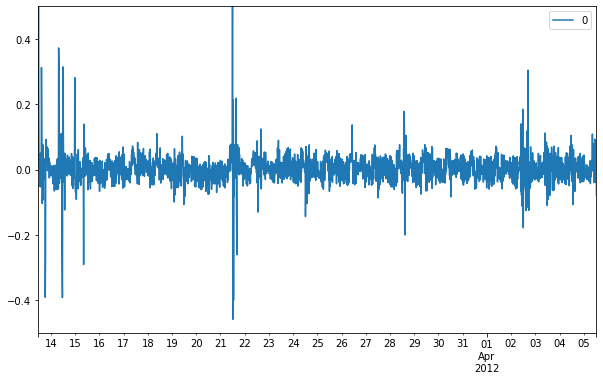

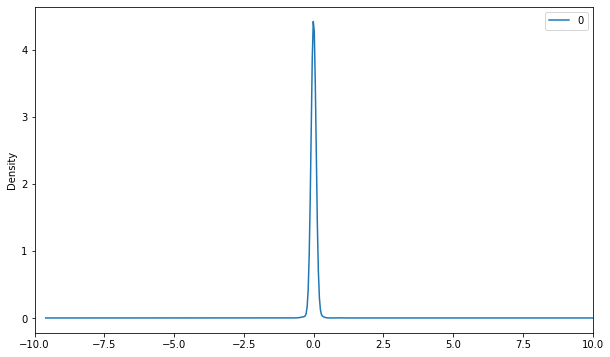

                 0
count  2212.000000
mean      0.008274
std       0.382405
min      -0.459245
25%      -0.021358
50%      -0.001338
75%       0.022401
max      17.827500


In [51]:
# line plot of residuals
residuals = pd.DataFrame(model.resid)
residuals.plot()
plt.ylim(-0.5, 0.5)
plt.show()
# density plot of residuals
residuals.plot(kind='kde')
plt.xlim(-10, 10)
plt.show()
# summary stats of residuals
print(residuals.describe())

The plots have a look of a discrete white noise indicating good fit. 

#### **<span style = 'color:purple'>3.3.4 Evaluation metrics using Forecasts</span>**<a id ="Metrics"></a>
[<div style="text-align: right"> Back to Table of contents</div>](#Table)

To evaluate the forecasts, let’s compute a comprehensive set of metrics, namely, the MAPE, ME, MAE, MPE, RMSE, corr and minmax.

In [52]:
def evaluation_metrics(forecast, actual):
    print('MAPE :',  np.mean(np.abs(forecast - actual)/np.abs(actual))) 
    print('ME :',np.mean(forecast - actual))             
    print('MAE :', np.mean(np.abs(forecast - actual)))    
    print('MPE :', np.mean((forecast - actual)/actual))   
    print('RMSE :',np.mean((forecast - actual)**2)**.5)  
    print('CORR :', np.corrcoef(forecast, actual)[0,1])   
    print('RSS :', np.sum((forecast - actual) ** 2))
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    print('MINMAX :', 1 - np.mean(mins/maxs))             

evaluation_metrics(df_test['Indoor_temperature_room'], df_test['forecast'])

MAPE : 0.09895791824810378
ME : -0.23622292767081818
MAE : 1.9484121472773825
MPE : -0.011630267700324517
RMSE : 2.433423173889202
CORR : 0.1882165335039646
RSS : 3268.694685457991
MINMAX : 0.09293880137287724


#### **<span style = 'color:purple'>3.3.5 Normality Test for Residuals</span>**<a id ="Normality"></a>
[<div style="text-align: right"> Back to Table of contents</div>](#Table)

##### **RMSFE**

RMSFE (root mean squared forecasting error) is very similar to RMSE. The only difference is that RMSFE has to be calculated on residual terms from predictions on unseen data (ie. Validation or Test set).
It is important to ensure that the residuals of validation predictions are normally distributed. For this use a PP-plot and test its normality with any or all of the Normality tests like: Shapiro Wilk test, Kolmogorov-Smirnov test, Jarque-Bera test, Anderson-Darling test (from both scipy and statsmodels), Kolmogorov-Smirnov, and D’Agostino K-squared tests.

The PP-plot(Probability-to-Probability) plots the data sample against the normal distribution plot in such a way that if normally distributed, the data points will form a straight line.

The normality tests determine how likely a data sample is from a normally distributed population using p-values. The null hypothesis for each test is that “the sample came from a normally distributed population”. This means that if the resulting p-values are below a chosen alpha value, then the null hypothesis is rejected. Thus there is evidence to suggest that the data comes from a non-normal distribution. For this project, use an Alpha value of 0.01.

The below executed normality tests determine how likely a data sample is from a normally distributed population using p-values. The null hypothesis for each test is that “the sample came from a normally distributed population”.


In [53]:
from scipy import stats
from statsmodels.stats.diagnostic import normal_ad
import statsmodels
residuals = sorted([x - y for x, y in zip(df_test['forecast'].values , df_test['Indoor_temperature_room'].values)])
sw_result = stats.shapiro(residuals)#Shapiro Wilk test
KS_result = stats.kstest(residuals, 'norm')#Kolmogorov-Smirnov test 
JB_result = stats.jarque_bera(residuals) #Jarque-Bera test
AD_result = stats.anderson(residuals)#Anderson-Darling test
ad_result = normal_ad(np.array(residuals), axis=0)#Anderson-Darling test
dag_result = stats.normaltest(residuals, axis=0, nan_policy='propagate')#D’Agostino’s K-squared test
lf_result = statsmodels.stats.diagnostic.lilliefors(residuals)#Lilliefors test
#print(f'\n \n Residulas for Indoor_temperature_room')
#print(residuals)
print(f'\n \n Shapiro Wilk test results for Indoor_temperature_room')
print(sw_result)
print(f'\n \n Kolmogorov-Smirnov test results for Indoor_temperature_room')
print(KS_result)
print(f'\n \n Jarque-Bera test results for Indoor_temperature_room')
print(JB_result)
print(f'\n \n Anderson-Darling test results for Indoor_temperature_room')
print(AD_result)
print(f'\n \n Anderson-Darling test results for Indoor_temperature_room')
print(ad_result)
print(f'\n \n D’Agostino’s K-squared test results for Indoor_temperature_room')
print(dag_result)
print(f'\n \n Lilliefors test results for Indoor_temperature_room')
print(lf_result)


 
 Shapiro Wilk test results for Indoor_temperature_room
ShapiroResult(statistic=0.9783470630645752, pvalue=2.723508600865898e-07)

 
 Kolmogorov-Smirnov test results for Indoor_temperature_room
KstestResult(statistic=0.23472125619736528, pvalue=3.1198258529755528e-27)

 
 Jarque-Bera test results for Indoor_temperature_room
Jarque_beraResult(statistic=11.257914176352445, pvalue=0.00359231984723396)

 
 Anderson-Darling test results for Indoor_temperature_room
AndersonResult(statistic=3.179226120705607, critical_values=array([0.572, 0.651, 0.781, 0.911, 1.084]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))

 
 Anderson-Darling test results for Indoor_temperature_room
(3.179226120705607, 5.6288057333751114e-08)

 
 D’Agostino’s K-squared test results for Indoor_temperature_room
NormaltestResult(statistic=16.250699680902155, pvalue=0.00029594117974905226)

 
 Lilliefors test results for Indoor_temperature_room
(0.08909352079810151, 0.0009999999999998899)


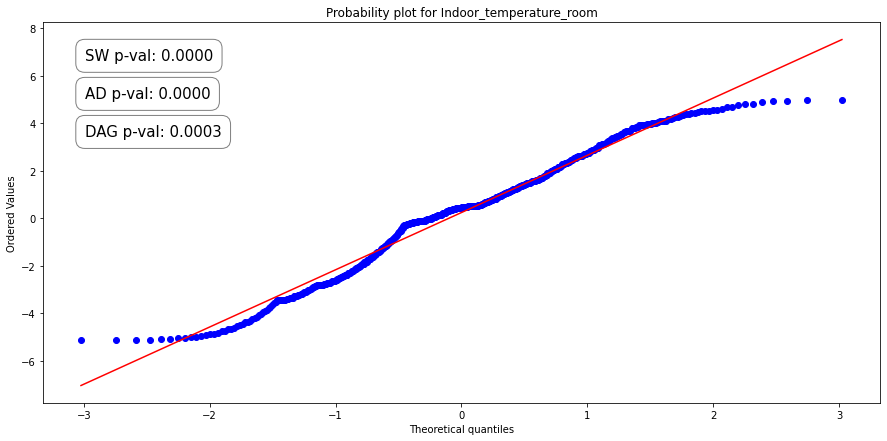

In [54]:
#fig, ax = plt.subplots(2, 1, figsize=(15,7))
plt.figure(figsize=(15,7))
res = stats.probplot(residuals, plot=plt)
plt.title(f'Probability plot for Indoor_temperature_room')
ax = plt.gca()
ax.annotate("SW p-val: {:.4f}".format(sw_result[1]), xy=(0.05,0.9), xycoords='axes fraction', fontsize=15,
            bbox=dict(boxstyle="round", fc="none", ec="gray", pad=0.6))
ax.annotate("AD p-val: {:.4f}".format(ad_result[1]), xy=(0.05,0.8), xycoords='axes fraction', fontsize=15,
            bbox=dict(boxstyle="round", fc="none", ec="gray", pad=0.6))
ax.annotate("DAG p-val: {:.4f}".format(dag_result[1]), xy=(0.05,0.7), xycoords='axes fraction', fontsize=15,
            bbox=dict(boxstyle="round", fc="none", ec="gray", pad=0.6));

Just to compare draw 2 probability plots, one using Scipy‘s probplot, and the other from Statsmodels‘s QQ-plot.

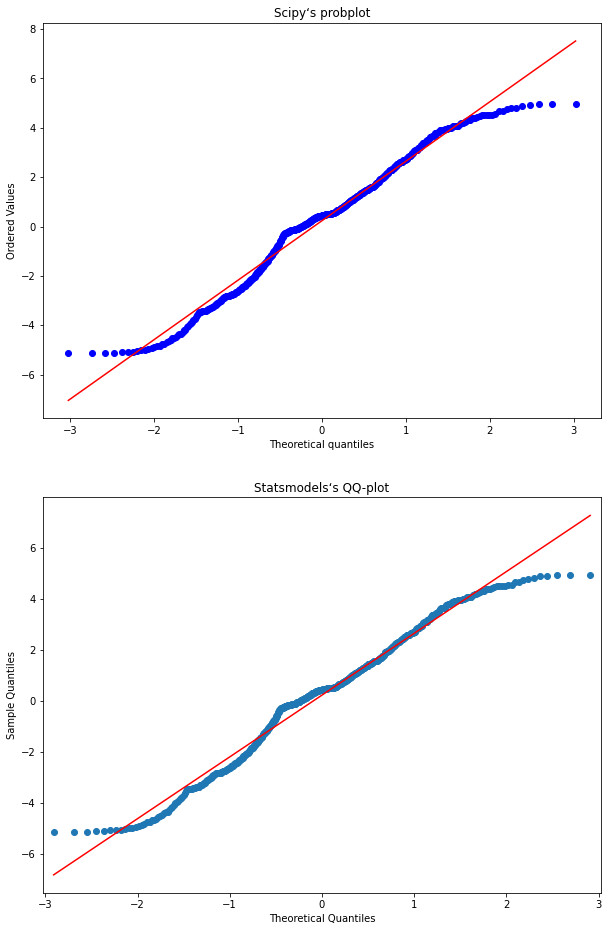

In [55]:
fig, ax = plt.subplots(2, 1, figsize=(10, 16))
# draw using scipy's probplot
stats.probplot(residuals, plot=ax[0])
ax[0].set_title(f'Scipy‘s probplot')
# draw using statsmodel's qqplot
import statsmodels.api as sm
sm.qqplot(np.array(residuals), line='r', ax=ax[1])
plt.title('Statsmodels‘s QQ-plot')
plt.show()

The 2 plots are identical. Except for some very minor differences in the aesthetic aspect, they show the same information. Hence, using either of the 2 just depends on user's preference, they both give the same QQ-plot.

All the above normality tests returned a p-value greater than the alpha value of 0.01. That means that the null hypothesis is to be rejected and it is likely that the data points do not come from a normal distribution. Also, The relationship between the sample percentiles and theoretical percentiles is not linear. Again, the condition that the error terms are normally distributed is not met.

Anyways, use RMSFE to generate prediction intervals on our forecast.

#### **<span style = 'color:purple'>3.3.6 Autocorrelation of residuals</span>**<a id ="Autocorrelation"></a>
[<div style="text-align: right"> Back to Table of contents</div>](#Table)
As with all statistical properties, we require a statistical test to ultimately decide whether there is autocorrelation in our residuals or not. A Ljung-Box test, which is pronounced as “Young”  is used to detect autocorrelation in a time series. The Ljung-Box test examines autocorrelation at all lag intervals below a specified maximum and returns arrays containing the outputs for every tested lag interval.

Check for autocorrelation quantitatively using a Ljung-Box test and see if any of the lags have significant autocorrelation in the residuals of the above model. Use the acorr_ljungbox function from the statsmodels package and a max lag interval of 10.

The Ljung-Box test uses the following hypotheses:

H0: The residuals are independently distributed.

HA: The residuals are not independently distributed; they exhibit serial correlation.


In [56]:
import statsmodels.stats.diagnostic as smd
ljung_box = smd.acorr_ljungbox(model.resid, lags=10, return_df=True)
print("P-Values:", ljung_box.lb_pvalue.tolist(), "\n")
if (ljung_box.lb_pvalue < 0.05).any():
    print("The residuals are autocorrelated.")
else:
    print("The residuals are not autocorrelated.")

P-Values: [0.4445900490148281, 0.743564180555234, 0.8978276063490614, 0.9636271878301891, 0.987531416375862, 0.9961629515125888, 0.9988115389010969, 0.9996481827112177, 0.9998995455702363, 0.9999738336769924] 

The residuals are not autocorrelated.


#### **<span style = 'color:purple'>3.3.7 Heteroscedasticity Analysis of Residuals: Breusch-Pagan, Goldfeld-Quandt and White Tests in Python</span>**<a id ="Heteroscedasticity"></a>
[<div style="text-align: right"> Back to Table of contents</div>](#Table)

Test for heteroskedasticity of standardized residuals

Tests whether the sum-of-squares in the first third of the sample is significantly different than the sum-of-squares in the last third of the sample. Analogous to a Goldfeld-Quandt test. The null hypothesis is of no heteroskedasticity.

##### **Breush-Pagan test:**
A Breusch-Pagan test uses the following null and alternative hypotheses:

The null hypothesis (H0): Homoscedasticity is present.

The alternative hypothesis: (Ha): Homoscedasticity is not present (i.e. heteroscedasticity exists).

If the p-value of the test results is smaller than alpha (significance level) then we can reject H0 and conclude that the data is heteroscedastic. We will use 0.05 as the signifcance level parameter.

We need to convert df[‘Indoor_temperature_room’] into a 2d array since this is required for as one of the input in Breusch-Pagan test

In [57]:
def test_model(col):
    s = []
    for i in col:
        a = [1,i]
        s.append(a)
    return (np.array(s))
Het = df_train.iloc[8:,]

exog = test_model(df_train['Indoor_temperature_room'])

# Method 1
from statsmodels.stats.diagnostic import het_breuschpagan
breusch_pagan_test = het_breuschpagan(model.resid, exog)
print(breusch_pagan_test)
print ('\n Het_breuschpagan-test p_value:', breusch_pagan_test[1])
if breusch_pagan_test[1] > 0.05:
    print("The residuals are not heteroscedastic.")
if breusch_pagan_test[1] < 0.05:
    print("The residuals are heteroscedastic.")

(0.08495243878133918, 0.770694931026354, 0.08487888805382358, 0.7708187799806155)

 Het_breuschpagan-test p_value: 0.770694931026354
The residuals are not heteroscedastic.


In [58]:
# Method 2
import statsmodels.stats.api as sms
from statsmodels.compat import lzip
import statsmodels.tools.tools as smt
name = ["Lagrange multiplier statistic", "p-value", "f-value", "f p-value"]
test = sms.het_breuschpagan(model.resid, exog_het= exog )
lzip(name, test)

[('Lagrange multiplier statistic', 0.08495243878133918),
 ('p-value', 0.770694931026354),
 ('f-value', 0.08487888805382358),
 ('f p-value', 0.7708187799806155)]

##### **Goldfeld-Quandt test**

In [59]:
name = ["F statistic", "p-value"]
GQ_test = sms.het_goldfeldquandt(model.resid, exog)
print(lzip(name, test))
if GQ_test[1] > 0.05:
    print("The residuals are not heteroscedastic.")
if GQ_test[1] < 0.05:
    print("The residuals are heteroscedastic.")

[('F statistic', 0.08495243878133918), ('p-value', 0.770694931026354)]
The residuals are not heteroscedastic.


##### **White test**

White’s test uses the following null and alternative hypotheses:

Null (H0): Homoscedasticity is present (residuals are equally scattered)

Alternative (HA): Heteroscedasticity is present (residuals are not equally scattered)

In [60]:
from statsmodels.stats.diagnostic import het_white
#define labels to use for output of White's test
labels = ['Test Statistic', 'Test Statistic p-value', 'F-Statistic', 'F-Test p-value']
white_test = het_white(model.resid.values,exog) 
#print results of White's test
print(dict(zip(labels, white_test)))
if white_test[1] > 0.05:
    print("The residuals are not heteroscedastic.")
if white_test[1] < 0.05:
    print("The residuals are heteroscedastic.")

{'Test Statistic': 0.7490241733217067, 'Test Statistic p-value': 0.6876246982190992, 'F-Statistic': 0.3741308465108078, 'F-Test p-value': 0.6879304780210265}
The residuals are not heteroscedastic.


#### **<span style = 'color:purple'>3.3.8 Prediction Intervals</span>**<a id ="Intervals"></a>
[<div style="text-align: right"> Back to Table of contents</div>](#Table)
Prediction intervals are used to provide a range where the forecast is likely to be with a specific degree of confidence. For example, if you made 100 forecasts with 95% confidence, you would have 95 out of 100 forecasts fall within the prediction interval. By using a prediction interval you can account for uncertainty in the forecast, and the random variation of the data.

The first step here is to choose the degree of confidence that we want to provide. Do we want our prediction to fall within the prediction interval of 75%, 95%, or 99% of the time? We will use a prediction interval of 95%. In a normal distribution, 95% of data points fall within 1.96 standard deviations of the mean, so we multiply 1.96 by the RMSFE to get get the prediction interval size. This is shown in the plot below.


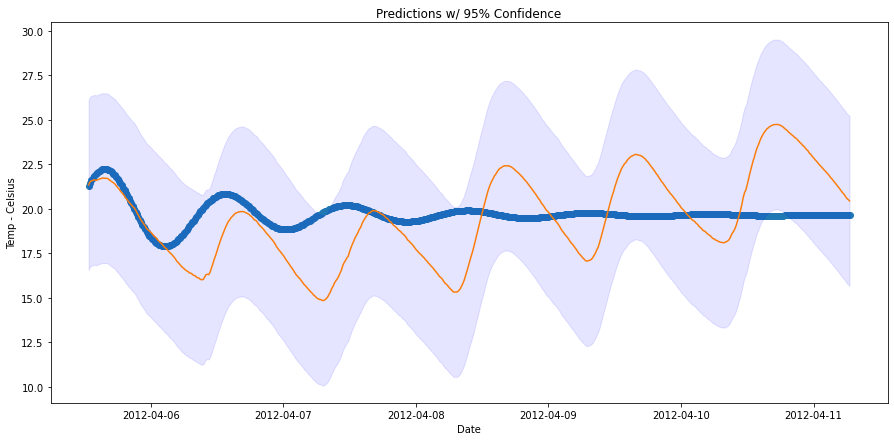

In [61]:
residuals = sorted([x - y for x, y in zip(df_test['forecast'].values , df_test['Indoor_temperature_room'].values)])
RMSFE = np.sqrt(sum([x**2 for x in residuals]) / len(residuals))
band_size = 1.96*RMSFE
    
fig, ax = plt.subplots(figsize=(15,7))
ax.plot(df_test.index, df_test['Indoor_temperature_room'], color='#fc7d0b', label='Valid')
ax.scatter(df_test.index, df_test['forecast'])
ax.fill_between(df_test.index, (df_test['Indoor_temperature_room']-band_size), (df_test['Indoor_temperature_room']+band_size), color='b', alpha=.1)
ax.set_title("Predictions w/ 95% Confidence")
ax.set_xlabel('Date')
ax.set_ylabel('Temp - Celsius')
plt.show()

In general, it is recommended to forecast less than 5 values in advance, because the error in forecasts increases if we forecast far ahead in the future. This is because the ARIMA model uses the past values to predict the future values, and if we predict too much into the future, the error-prone predictions obtained previously would be used as training data.

****
#### **<span style = 'color:purple'>3.3.9 Checking for Conditional Heteroskedasticity</span>**<a id ="Conditional-Heteroskedasticity"></a>
[<div style="text-align: right"> Back to Table of contents</div>](#Table)
Now we plot the residuals to decide if they possess evidence of conditional heteroskedastic behaviour. 

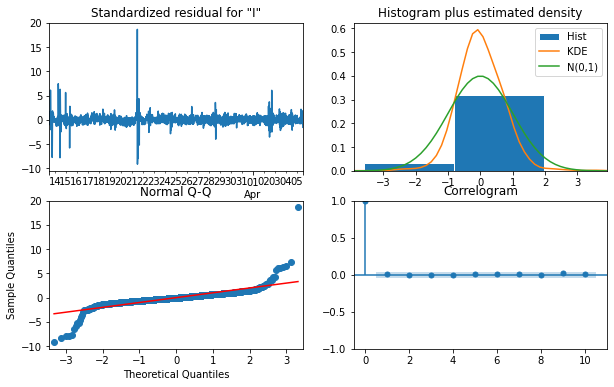

In [62]:
diagnostics = model.plot_diagnostics()

Notice the time series looks just like white noise. Now its time to see what happens when the square of the residuals are plotted. 

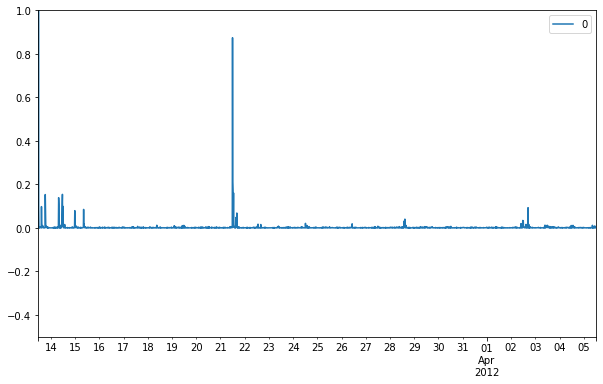

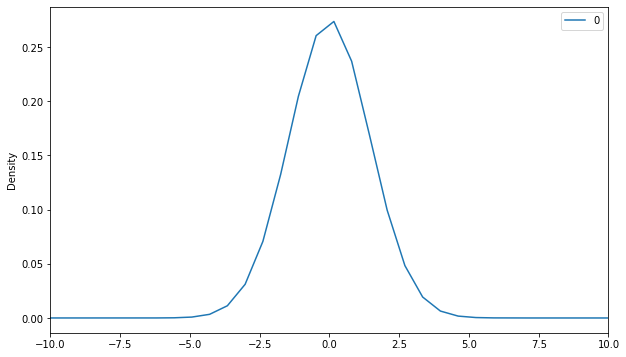

                  0
count  2.212000e+03
mean   1.462357e-01
std    6.757515e+00
min    3.472494e-11
25%    1.087508e-04
50%    4.785279e-04
75%    1.458276e-03
max    3.178198e+02


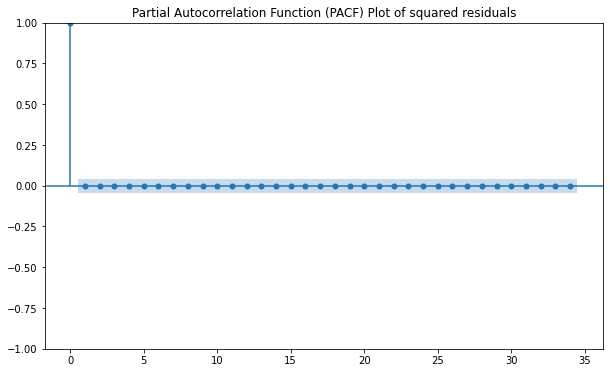

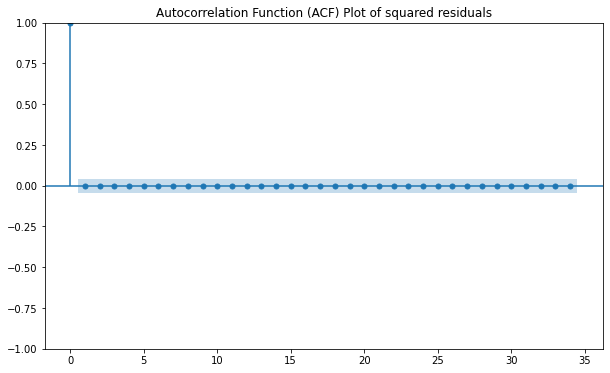

In [63]:
#line plot of residuals
residuals_squared = pd.DataFrame((model.resid)**2)
residuals_squared.plot()
plt.ylim(-0.5, 1)
plt.show()
# density plot of residuals
residuals_squared.plot(kind='kde')
plt.xlim(-10, 10)
plt.show()
# summary stats of residuals
print(residuals_squared.describe())
plot_pacf(model.resid**2, title = "Partial Autocorrelation Function (PACF) Plot of squared residuals");
plot_acf(model.resid**2, title = "Autocorrelation Function (ACF) Plot of squared residuals");

This is what looks like a realisation of a discrete white noise process, indicating that the serial correlation present in the original time series is “explained”  well with an appropriate ARIMA(p,d,q) model with order 3,1,2. Both residuals and squared residulas show no correlation and exhibits white noise. There is mo evidence of a conditionally heteroskedastic process either. So no further ARCH and GARCH analysis are required. 

## **<span style='color:green'>4. SARIMA model building</span>**<a id ='Sarima'></a>
[<div style="text-align: right"> Back to Table of contents</div>](#Table)
Many time-series methods may perform better when a time-series is stationary, since forecasting values becomes a far easier task for a stationary time series. ARIMAs that include differencing (i.e., d > 0) assume that the data becomes stationary after differencing. This is called difference-stationary. Auto-correlation plots are an easy way to determine whether your time series is sufficiently stationary for modeling. If the plot does not appear relatively stationary, your model will likely need a differencing term. These can be determined by using an Augmented Dickey-Fuller test, or various other statistical testing methods. 

### **<span style = 'color:brown'>4.1 Model Identification & Estimation: Finding Non-seasonal and Seasonal Orders</span>**<a id = 'Finding-orders'></a>
[<div style="text-align: right"> Back to Table of contents</div>](#Table)


#### **<span style = 'color:purple'>4.1.1 Plot the decomposition of a time series.</span>**<a id ="decomposition"></a>
[<div style="text-align: right"> Back to Table of contents</div>](#Table)

Time series decomposition works by splitting a time series into three components: seasonality, trends and random fluctiation. 

Time series decomposition is a mathematical procedure which transforms a time series into multiple different time series. The original time series is often split into 3 component series:

Seasonal: Patterns that repeat with a fixed period of time. 

Trend: The underlying trend of the metrics. 

Random: Also call “noise”, “irregular” or “remainder,” this is the residuals of the original time series after the seasonal and trend series are removed.

Plots the results of the time series decomposition in four plots: the ‘x’, ‘trend’, ‘seasonal’, and ‘random’ components.

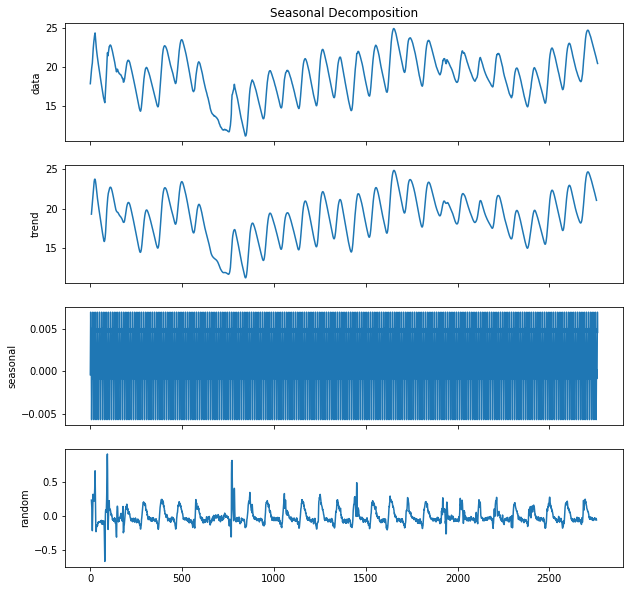

In [64]:
!pip install pmdarima --quiet
import pmdarima as pm
from pmdarima import arima
from pmdarima import utils
figure_kwargs = {'figsize': (10, 10)}
decomposed = arima.decompose(df['Indoor_temperature_room'].values, type_= "additive", m=12)
axes = utils.decomposed_plot(decomposed, figure_kwargs=figure_kwargs,
                             show=False)
axes[0].set_title("Seasonal Decomposition");

#### **<span style = 'color:purple'>4.1.2 Plot PACF & ACF Plots</span>**<a id ="correlogram"></a>
[<div style="text-align: right"> Back to Table of contents</div>](#Table)

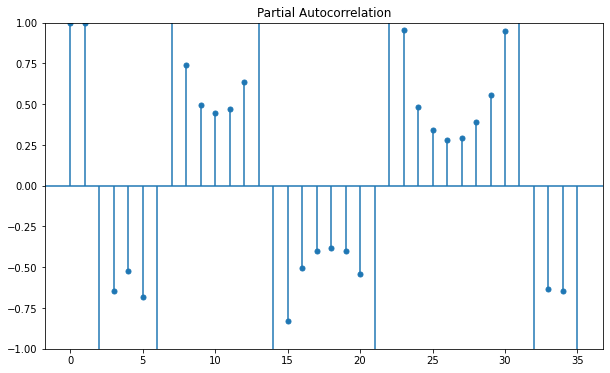

In [65]:
import pmdarima as pm
pm.plot_pacf(df['Indoor_temperature_room'],)

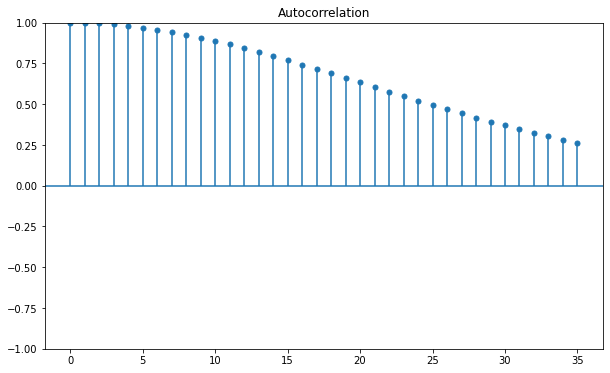

In [66]:
import pmdarima as pm
pm.plot_acf(df['Indoor_temperature_room'])

#### **<span style = 'color:purple'>4.1.3 Estimation of parameters using AIC, BIC, FPE and HQIC</span>**<a id ="AIC"></a>
[<div style="text-align: right"> Back to Table of contents</div>](#Table)

**Method 1:**
```python
import warnings
warnings.simplefilter(action='ignore', category=Warning)
import itertools
p=[0, 1, 2, 3, 6, 8]
d=[0,1]
q=[0,1,2,3]

min_aic=10000
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 4) for x in list(itertools.product(p, d, q))]

#For possible combinations of (p,d,q) and (P,D,Q) we loop over and try to observe how the model performs
for param in pdq:
    for param_seasonal in seasonal_pdq:
        mod = sm.tsa.statespace.SARIMAX(df_train['Indoor_temperature_room'],order=param,seasonal_order=param_seasonal,enforce_stationarity=False,enforce_invertibility=False)
        results = mod.fit()
        print('SARIMA{}x{} - AIC:{}'.format(param,param_seasonal,results.aic))
        if(results.aic<min_aic):
            min_aic=results.aic
            min_param=param
            min_seasonal=param_seasonal
            
print('aic: {:6.5f} | order: {} seasonal_order: {}'.format(min_aic, min_param, min_seasonal))     
``````

Since it takes a couple of hours to finish running this code, it is better to make it inactive to save computation time. Running this code, Sarimax order obtained are the following:

order: (3, 1, 3)

Seasonal order: (3, 0, 0, 4)

AIC : -6905.864947411554  

**Method 2:**
```python
import warnings
warnings.simplefilter(action='ignore', category=Warning)

from statsmodels.tsa.statespace.sarimax import SARIMAX
best_score, best_order = np.inf, None
for i in [3,5, 6, 8]:
    for j in [0, 1]:
        for k in [0, 1,2,3]:
            model = SARIMAX(df_train['Indoor_temperature_room'], freq = '15T', order=(i,1,2), seasonal_order=(j,0,k,4)).fit()
            model_aic = model.aic
            if model_aic < best_score:
                best_score = model_aic
                best_order = (i, j, k)
                
print('aic: {:6.5f} | order: {}'.format(best_score, best_order)) 
```

**Method 3:**
```python
from statsmodels.tsa.statespace.sarimax import SARIMAX
for i in [1,2,3,4]:
    model = SARIMAX(df_train['Indoor_temperature_room'], order=(8, 1, 2),seasonal_order=(4,0,i,4))
    result = model.fit()
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    #print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')
```

#### **<span style = 'color:purple'>4.1.4 Using auto_arima</span>**<a id ="auto-arima"></a>
[<div style="text-align: right"> Back to Table of contents</div>](#Table)

Seasonality can manifest itself in timeseries data in unexpected ways. Sometimes trends are partially dependent on the time of year or month. Other times, they may be related to weather patterns. In either case, seasonality is a real consideration that must be made. The pmdarima package provides a test of seasonality for including seasonal terms in ARIMA models.
Seasonal ARIMA models have three parameters that heavily resemble our p, d and q parameters:

P: The order of the seasonal component for the auto-regressive (AR) model.

D: The integration order of the seasonal process.

Q: The order of the seasonal component of the moving average (MA) model.

P and Q and be estimated similarly to p and q via auto_arima,

D can be estimated via a Canova-Hansen test.

However 'm' generally requires subject matter knowledge of the data.

In [67]:
from pmdarima.arima import auto_arima
from pmdarima.arima.stationarity import ADFTest

# Test whether we should difference at the alpha=0.05
# significance level
adf_test = ADFTest(alpha=0.05)
# Test whether we should difference at the alpha=0.05
# significance level
adf_test = ADFTest(alpha=0.05)
p_val, should_diff = adf_test.should_diff(df_train['Indoor_temperature_room'])  # (0.01, False)
#p_val1, should_diff1 = adf_test.should_diff(df_train_differenced['Indoor_temperature_room'])  # (0.01, False)
p_val, should_diff

(0.01, False)

The verdict, as per the pmdarima ADF test, is that the original data should not be differenced. In other words, even a first differencing is not required. Pmdarima also provides a more handy interface for estimating d parameter more directly.

In [68]:
from pmdarima.arima.utils import ndiffs

# Estimate the number of differences using an ADF test:
n_adf = ndiffs(df_train['Indoor_temperature_room'], test='adf')  

# Or a KPSS test (auto_arima default):
n_kpss = ndiffs(df_train['Indoor_temperature_room'], test='kpss')  

# Or a PP test:
n_pp = ndiffs(df_train['Indoor_temperature_room'], test='pp')  
#assert n_adf == n_kpss == n_pp == 0
n_adf, n_kpss, n_pp

(0, 1, 0)

Use a Canova-Hansen test to estimate seasonal differencing term:

In [69]:
from pmdarima.arima.utils import nsdiffs
D = nsdiffs(df_train['Indoor_temperature_room'],
            m=10,  # commonly requires knowledge of dataset
            max_D=12,
            test='ch')  

# or use the OCSB test (by default)
D2 = nsdiffs(df_train['Indoor_temperature_room'],
        m=10,
        max_D=12,
        test='ocsb')  
D, D2

(0, 0)

In [70]:
from pmdarima.arima import auto_arima
arima_model = auto_arima(df_train['Indoor_temperature_room'], start_p = 1, start_q = 1, 
                      max_p = 9, max_q = 4, m = 4, 
                      start_P = 0, start_Q = 0, max_P = 4, max_Q = 4, seasonal = True, 
                      start_d = 0, max_d = 2, max_D = 2, start_D = 0, trace = True,)
df_test['forecast'] = arima_model.predict(n_periods=len(df_test))
arima_model.summary

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[4] intercept   : AIC=-6780.384, Time=1.07 sec
 ARIMA(0,1,0)(0,0,0)[4] intercept   : AIC=-2182.041, Time=0.19 sec
 ARIMA(1,1,0)(1,0,0)[4] intercept   : AIC=-6696.733, Time=3.77 sec
 ARIMA(0,1,1)(0,0,1)[4] intercept   : AIC=-5111.413, Time=2.40 sec
 ARIMA(0,1,0)(0,0,0)[4]             : AIC=-2183.811, Time=0.13 sec
 ARIMA(1,1,1)(1,0,0)[4] intercept   : AIC=-6778.403, Time=4.64 sec
 ARIMA(1,1,1)(0,0,1)[4] intercept   : AIC=-6778.231, Time=2.70 sec
 ARIMA(1,1,1)(1,0,1)[4] intercept   : AIC=-6776.325, Time=4.42 sec
 ARIMA(0,1,1)(0,0,0)[4] intercept   : AIC=-4191.884, Time=0.53 sec
 ARIMA(1,1,0)(0,0,0)[4] intercept   : AIC=-6698.027, Time=0.37 sec
 ARIMA(2,1,1)(0,0,0)[4] intercept   : AIC=-6748.202, Time=1.41 sec
 ARIMA(1,1,2)(0,0,0)[4] intercept   : AIC=-6783.200, Time=2.39 sec
 ARIMA(1,1,2)(1,0,0)[4] intercept   : AIC=-6781.276, Time=5.16 sec
 ARIMA(1,1,2)(0,0,1)[4] intercept   : AIC=-6781.242, Time=3.27 sec
 ARIMA(1,1,2)(1,0,1

<function pmdarima.arima.arima.ARIMA.summary(self)>

In [71]:
get_parametes =arima_model.get_params()
print(type(get_parametes))
get_parametes

<class 'dict'>


{'maxiter': 50,
 'method': 'lbfgs',
 'order': (3, 1, 3),
 'out_of_sample_size': 0,
 'scoring': 'mse',
 'scoring_args': {},
 'seasonal_order': (0, 0, 1, 4),
 'start_params': None,
 'suppress_warnings': True,
 'trend': None,
 'with_intercept': False}

### **<span style = 'color:brown'>4.2 Model Diagnostics</span>**<a id = 'Sarima-Diagnostics'></a>
[<div style="text-align: right"> Back to Table of contents</div>](#Table)

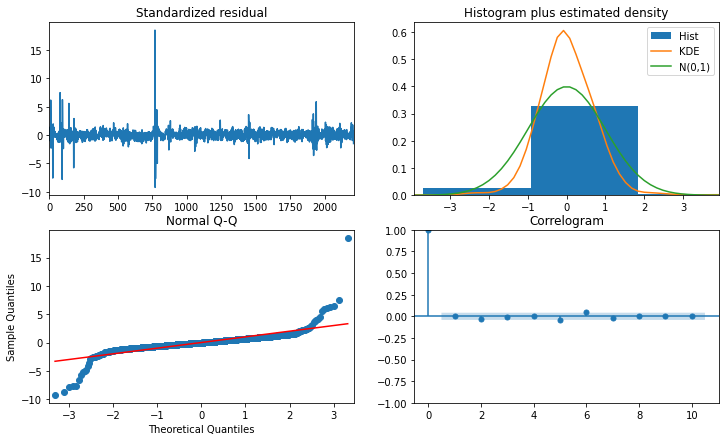

In [72]:
plot = arima_model.plot_diagnostics(figsize=(12, 7))

Looking at the graph above, there are several points that fall far away from the red line in Q_Q plot. This is indicative of the errors not being normally distributed, in fact our model suffers from “heavy tails”. Hence it is more likely to see extreme values than to be expected if the data was truly normally distributed. However, it is good to know what assumptions about the data are violating in this model.

##### **Ijung_Box Correlation test**

In [73]:
import statsmodels.stats.diagnostic as smd
residuals = sorted([x - y for x, y in zip(df_test['forecast'].values , df_test['Indoor_temperature_room'].values)])
ljung_box = smd.acorr_ljungbox(residuals, lags=10, return_df=True)
print("P-Values:", ljung_box.lb_pvalue.tolist(), "\n")
if (ljung_box.lb_pvalue < 0.05).any():
    print("The residuals are autocorrelated.")
else:
    print("The residuals are not autocorrelated.")

P-Values: [7.993449891242627e-121, 2.606000797929322e-236, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] 

The residuals are autocorrelated.


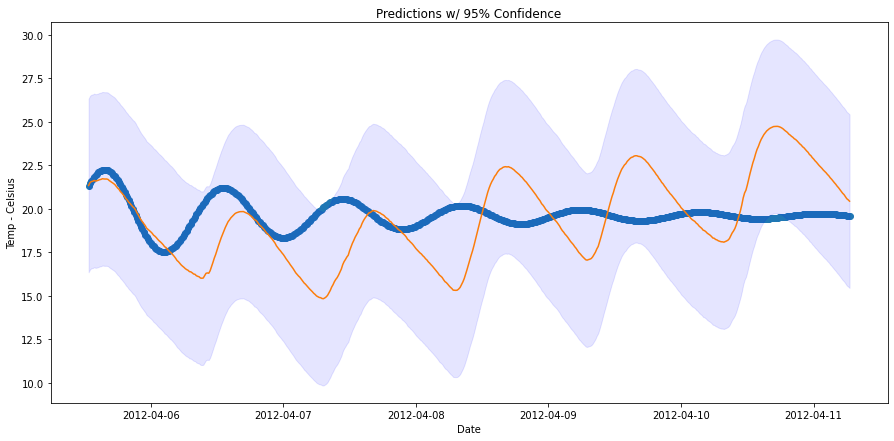

In [74]:
residuals = sorted([x - y for x, y in zip(df_test['forecast'].values , df_test['Indoor_temperature_room'].values)])
RMSFE = np.sqrt(sum([x**2 for x in residuals]) / len(residuals))
band_size = 1.96*RMSFE
    
fig, ax = plt.subplots(figsize=(15,7))
ax.plot(df_test.index, df_test['Indoor_temperature_room'], color='#fc7d0b', label='Valid')
ax.scatter(df_test.index, df_test['forecast'])
ax.fill_between(df_test.index, (df_test['Indoor_temperature_room']-band_size), (df_test['Indoor_temperature_room']+band_size), color='b', alpha=.1)
ax.set_title("Predictions w/ 95% Confidence")
ax.set_xlabel('Date')
ax.set_ylabel('Temp - Celsius')
plt.show()

Now use the best parameter obtained to forecast the values for the testing dataset given. Plot the forecasted and actual values together in the same graph. 

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.14624D+00    |proj g|=  1.58458D+01


 This problem is unconstrained.



At iterate    5    f= -1.34891D+00    |proj g|=  8.52491D+00

At iterate   10    f= -1.54353D+00    |proj g|=  3.04175D+00

At iterate   15    f= -1.54850D+00    |proj g|=  1.03026D-02

At iterate   20    f= -1.54873D+00    |proj g|=  3.09271D-03

At iterate   25    f= -1.54877D+00    |proj g|=  5.99613D-03

At iterate   30    f= -1.55156D+00    |proj g|=  1.53778D-01

At iterate   35    f= -1.56047D+00    |proj g|=  3.09562D-02

At iterate   40    f= -1.56686D+00    |proj g|=  6.07970D-02

At iterate   45    f= -1.56697D+00    |proj g|=  6.80839D-03

At iterate   50    f= -1.56704D+00    |proj g|=  5.20419D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

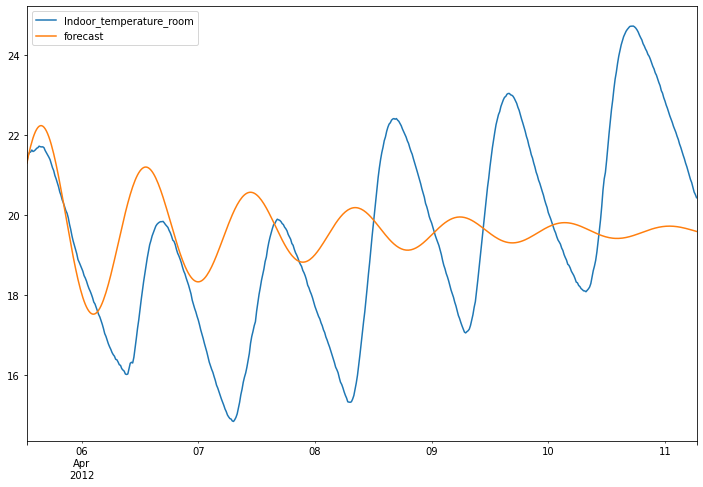

In [75]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.statespace.sarimax import SARIMAXResults
model=SARIMAX(df_train['Indoor_temperature_room'],order=(3, 1, 3),seasonal_order=(0, 0, 1, 4),maxiter=15, simple_differencing = False )
results=model.fit()
df_test['forecast']= results.predict(start=len(df_train),end=len(df)-1,dynamic=True)

df_test[['Indoor_temperature_room','forecast']].plot(figsize=(12,8));

##### **Breusch_Godfrey Correlation test**

In [76]:
import statsmodels.stats.diagnostic as smd
breusch_godfrey = smd.acorr_breusch_godfrey(results, nlags=4)
print("\n P-Values:", breusch_godfrey)
if (breusch_godfrey[0]< 0.05):
    print("The residuals are autocorrelated.")
else:
    print("The residuals are not autocorrelated.")


 P-Values: (0.5541641461292532, 0.9680183571722939, 0.1382625170690271, 0.9681162605003084)
The residuals are not autocorrelated.


In [77]:
evaluation_metrics(df_test['Indoor_temperature_room'], df_test['forecast'])

MAPE : 0.10273212805203137
ME : -0.1788601807081275
MAE : 2.02443355325407
MPE : -0.007765438355650158
RMSE : 2.542335626996301
CORR : 0.0686044245194152
RSS : 3567.8356830426615
MINMAX : 0.09607152036968891


### **4.3 Model Forecasting**
[<div style="text-align: right"> Back to Table of contents</div>](#Table)

In [78]:
test=pd.read_csv("../input/smart-homes-temperature-time-series-forecasting/test.csv")
test['forecast'] = results.forecast(len(test)).values
#test['forecast'] = forecast
Final = test[['Id', 'forecast']]
Final.columns = ['Id', 'Indoor_temperature_room']
Final.to_csv('submission1.csv', index = False)
Final

,Id,Indoor_temperature_room
0,2764,21.306463
1,2765,21.462048
2,2766,21.593981
3,2767,21.723634
4,2768,21.835133
...,...,...
1368,4132,19.593178
1369,4133,19.593256
1370,4134,19.593334
1371,4135,19.593412


In [79]:
arima_model = auto_arima(df['Indoor_temperature_room'], start_p = 1, start_q = 1, 
                      max_p = 9, max_q = 4, m = 4, 
                      start_P = 0, start_Q = 0, max_P = 4, max_Q = 4, seasonal = True, 
                      start_d = 0, max_d = 2, max_D = 2, start_D = 0, trace = True,)
arima_model.summary

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[4] intercept   : AIC=-8808.722, Time=0.43 sec
 ARIMA(0,1,0)(0,0,0)[4] intercept   : AIC=-2861.602, Time=0.23 sec
 ARIMA(1,1,0)(1,0,0)[4] intercept   : AIC=-8695.581, Time=3.95 sec
 ARIMA(0,1,1)(0,0,1)[4] intercept   : AIC=-6614.922, Time=2.70 sec
 ARIMA(0,1,0)(0,0,0)[4]             : AIC=-2863.483, Time=0.14 sec
 ARIMA(1,1,1)(1,0,0)[4] intercept   : AIC=-8806.843, Time=3.25 sec
 ARIMA(1,1,1)(0,0,1)[4] intercept   : AIC=-8807.065, Time=4.21 sec
 ARIMA(1,1,1)(1,0,1)[4] intercept   : AIC=-8804.699, Time=5.26 sec
 ARIMA(0,1,1)(0,0,0)[4] intercept   : AIC=-5392.516, Time=0.61 sec
 ARIMA(1,1,0)(0,0,0)[4] intercept   : AIC=-8697.389, Time=0.23 sec
 ARIMA(2,1,1)(0,0,0)[4] intercept   : AIC=-8807.290, Time=2.63 sec
 ARIMA(1,1,2)(0,0,0)[4] intercept   : AIC=-8809.662, Time=1.35 sec
 ARIMA(1,1,2)(1,0,0)[4] intercept   : AIC=-8808.017, Time=6.30 sec
 ARIMA(1,1,2)(0,0,1)[4] intercept   : AIC=-8808.082, Time=6.54 sec
 ARIMA(1,1,2)(1,0,1

<function pmdarima.arima.arima.ARIMA.summary(self)>

In [80]:
test['forecast'] = arima_model.predict(n_periods=len(test))
Final = test[['Id', 'forecast']]
Final.columns = ['Id', 'Indoor_temperature_room']
Final.to_csv('submission2.csv', index = False)
Final

,Id,Indoor_temperature_room
0,2764,20.360725
1,2765,20.291356
2,2766,20.222467
3,2767,20.159821
4,2768,20.099691
...,...,...
1368,4132,19.304177
1369,4133,19.304177
1370,4134,19.304177
1371,4135,19.304177


### **References:**
1. [Tips to using auto_arima](https://alkaline-ml.com/pmdarima/tips_and_tricks.html)

2. [Seasonal periods](https://robjhyndman.com/hyndsight/seasonal-periods/)

3. [How to Interpret ARIMA Results](https://analyzingalpha.com/interpret-arima-results)

4. [Regression diagnostics](https://www.statsmodels.org/devel/examples/notebooks/generated/regression_diagnostics.html)

5. [Heteroscedasticity Analysis in Time Series Data](https://python.plainenglish.io/heteroscedasticity-analysis-in-time-series-data-fee51503cc0e)